In [2]:
from pynwb import NWBHDF5IO
#from nwbwidgets import nwb2widget
import h5py, glob, os
import numpy as np
import matplotlib.pyplot as plt
from dlab import sglx_analysis as sglx
from dlab import psth_and_raster as pr
import numpy as np
import pandas as pd
import os
import glob
from glob import glob 
from os.path import join


from tqdm.notebook import tqdm as tqdm
import glob
import pickle as pkl
import json
import datetime as dt
import h5py
from dlab import sglx_analysis as sglx
import math
# import jlh_ephys_tools as jlh
import matplotlib.pyplot as plt
# from open_ephys.analysis import Session
import seaborn as sns
import dlab.psth_and_raster as psth
from dlab.generalephys import cleanAxes
import matplotlib.lines as mlines

import statsmodels.api as sm
from statsmodels.formula.api import mixedlm
from scipy.ndimage import gaussian_filter1d
from scipy.stats import gaussian_kde



## This class will do a bunch of analysis for neuropixels data
### the data needs to be structured in an nwb already 
### Steps
### 1. make class instance for sepcific mouse: Mouse_id = Eopn3_Ephys(Path_to_Mouse_ID_NWB)
### 2. pass that class the path to the nwb made by running the make_nwb.py, Mouse_id_nwb_path = r"G:\Grant\rotation\nwb\pa_Bont2_nwb" 
### 3. you can check data by running some of these functions, 
#####     a. mouse_id.view_nwb(), view the full nwb
#####     b. mouse_id.units(), view the units and their spike times and other data 
#####     c. mouse_id.trials(), veiw the trials data, inclduing start_times, stop_times
### 4. Make the df used for finding avg spikes in a specified time window like this
##### a.  mouse_id.scatter_plot_2() 

In [52]:

class Eopn3_Ephys:

#  ----------------- Load data -----------------------------
    def __init__(self,nwb_path):
       self.nwb_path = nwb_path
       self.load_nwb()
 
    def nwb(self):
        if self.nwb is None:
            self.load_nwb()
        return self.nwb

    def load_nwb(self):
        nwb_path = self.nwb_path
        io = NWBHDF5IO(nwb_path, 'r')
        nwb = io.read()
        self.nwb = nwb
        return self.nwb
    
# prints the metaData associated with nwb
    def view_nwb(self):
        nwb = self.nwb
        print(nwb)

# creates a df of the trails associated with nwb. the Data frame contains data about each trail and its structure 
    def trials(self):
        nwb = self.nwb
        df_stim = nwb.trials.to_dataframe()
        # df_stim.loc[2100:2699,'contacts'] = '10r'  #specific to this recording, fixes an error in dataframe
        self.df_stim = df_stim
        return self.df_stim

# creates the Units Data frame associated with nwb. which contains all the data about the sorted spike units from the recording
    def units(self):
        nwb = self.nwb
        df_units = nwb.units.to_dataframe()
        self.df_units = df_units
        return self.df_units
    
# creates the optogenetics_states Data frame associated with nwb. which contains all the data about the optogenetics states 
    def optogenetics_states(self):
        nwb = self.nwb
        optogenetics_states_df = nwb.intervals['optogenetics_states'].to_dataframe()
        self.optogenetics_states_df = optogenetics_states_df
        return optogenetics_states_df
    
# creates the epochs Data frame associated with nwb. which contains just the entire recording length. 
    def epochs(self):
        nwb = self.nwb
        epochs_df = nwb.intervals['epochs'].to_dataframe()
        self.epochs_df = epochs_df
        return epochs_df

#  ----------------- End Load data -----------------------------


# ------------------------ Plotting ---------------------------------
    def singleUnit_pellet_detected(self,probeLetter,unit_indexNumber,save_fig_path,Savefig=False,):
        df_stim = self.trials()
        df_units = self.units() 

        df1 = df_units[df_units.probe==probeLetter][df_units.label==2]
        unit_index = df1.index.tolist()

        print(f"neuron indexs for {probeLetter} {list(unit_index)}")
       
        unit = unit_index[unit_indexNumber]
        print(f"looking at neuron/unit {unit}")
        f,ax=plt.subplots(1,1)
         
            # Set the background color and text color for this subplot
        ax.set_facecolor('white')
        ax.tick_params(color='black', labelcolor='black')
        for spine in ax.spines.values():
            spine.set_edgecolor('black')

        psth.psth_line(times=df1[df1.index==unit].spike_times.values[0],
                triggers=df_stim[(df_stim.stimulus=='pellet_delivery_timestamp') & (df_stim.optogenetics_LED_state == 0)].start_time.values,
                    ymax=70,binsize=0.05,axes=ax,color='#ffaa00')


        plt.tight_layout()
        if Savefig == True:
            f.savefig(save_fig_path)
            f.savefig(save_fig_path)
        else:
            pass

        f,ax=plt.subplots(2,1)
            # Set the background color and text color for these subplots
        for ax_ in ax:
            ax_.set_facecolor('white')
            ax_.tick_params(color='black', labelcolor='black')
            for spine in ax_.spines.values():
                spine.set_edgecolor('black')
        
        psth.raster(times=df1[df1.index==unit].spike_times.values[0],
                triggers=df_stim[(df_stim.stimulus=='pellet_detected_timestamp') & (df_stim.optogenetics_LED_state == 0)].start_time.values,
                    axes=ax[0],color='#487697',timeDomain=True,post=15,ms=8)
        psth.raster(times=df1[df1.index==unit].spike_times.values[0],
                triggers=df_stim[(df_stim.stimulus=='pellet_delivery_timestamp') ].start_time.values,
                    axes=ax[1],color='#ffaa00',timeDomain=True,post=15,ms=8)
        for ax_ in ax: ax_.set_xlim(-0.5,1.0)
     
        plt.tight_layout()
        # f.savefig('/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_raster.eps')

        df_stim = self.trials()
        df_units = self.units()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

# Save raters and psth_line plots for every unit in the selected probeLetter. Supply a unique save path for eachprobe 















# --------------- pellet detected --------------------
    def allUnits_pellet_detetced_0(self, probeLetter, brain_region ,save_fig_path ,Savefig=False):
        df_stim = self.trials()
        df_units = self.units()
        df_epoch = self.epochs()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

        for unit in unit_index:
            # Create a single figure with 3 subplots
            # f, ax = plt.subplots(3, 1)
            f, ax = plt.subplots(3, 1, figsize=(10, 15))

            f.suptitle(f"aligned to pellet dected; unit {unit}, probe {probeLetter} in {brain_region}", color='black')

            # Plot the psth_line in the first subplot
            ax[0].set_facecolor('white')
            ax[0].tick_params(color='black', labelcolor='black')
            for spine in ax[0].spines.values():
                spine.set_edgecolor('black')

            psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                        triggers=df_stim[(df_stim.stimulus == 'pellet_delivery_timestamp') & (df_stim.optogenetics_LED_state == 0)].start_time.values,
                        ymax=60, binsize=0.05, axes=ax[0],post=10, color='#ffaa00')
            
            # psth.psth_line(times=df1[df1.index==unit].spike_times.values[0],
            #             triggers=df_stim[(df_stim.stimulus=='pellet_delivery_timestamp')].start_time.values,
            #             ymax=60,binsize=0.05,axes=ax[0],post=10,color='#487697')
            ax[0].set_xlim(-2, 5)
         
            # Create custom legend handles
            handle1 = mlines.Line2D([], [], color='#ffaa00', label='baseline')
            handle2 = mlines.Line2D([], [], color='#487697', label='perturbation')

            # Add legend to the first subplot
            ax[0].legend(handles=[handle1,handle2], loc='upper right')
  

            # Plot the rasters in the second and third subplots
            for i, ax_ in enumerate(ax[1:]):
                ax_.set_facecolor('white')
                ax_.tick_params(color='black', labelcolor='black')
                for spine in ax_.spines.values():
                    spine.set_edgecolor('black')

            psth.raster(times=df1[df1.index == unit].spike_times.values[0],
                        triggers=df_stim[(df_stim.stimulus == 'pellet_delivery_timestamp') & (df_stim.optogenetics_LED_state == 0)].start_time.values,
                        axes=ax[1], color='#ffaa00', timeDomain=True, post=10, ms=8)

            psth.raster(times=df1[df1.index == unit].spike_times.values[0],
                        triggers=df_stim[(df_stim.stimulus == 'pellet_delivery_timestamp')].start_time.values,
                        axes=ax[2], color='#487697', timeDomain=True, post=10, ms=8)
            ax[1].set_xlim(-2, 5)
            ax[2].set_xlim(-2, 5)
            ax[1].set_title('baseline', color='black')
            ax[2].set_title('perturbation', color='black')


            plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle
            if Savefig:
                f.savefig(f"{save_fig_path}{unit}.png")

            plt.close(f)  # Close the figure to free up memory 

    def allUnits_pellet_detetced_1(self, probeLetter, brain_region, save_fig_path, Savefig=False):
        df_stim = self.trials()
        df_units = self.units()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

        n_units_per_image = 20  # Number of units per image
        n_cols = 4  # Number of columns per image
        n_rows = 5  # Number of rows per image

        for i in range(0, len(unit_index), n_units_per_image):
            f, axarr = plt.subplots(n_rows, n_cols, figsize=(15, 15))  # Create a new figure for every 20 units

            f.suptitle(f"Aligned pellet_detected events for probe {probeLetter} in {brain_region}", color='black')

            for j in range(n_units_per_image):
                if i + j >= len(unit_index):
                    break  # Exit the loop if we've reached the end of the unit list

                unit = unit_index[i + j]
                row = j // n_cols
                col = j % n_cols
                ax = axarr[row, col]

                ax.set_facecolor('white')
                ax.tick_params(color='black', labelcolor='black', labelsize=4)
                for spine in ax.spines.values():
                    spine.set_edgecolor('black')

                
                psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=df_stim[(df_stim.stimulus == 'pellet_delivery_timestamp') & (df_stim.optogenetics_LED_state == 0)].start_time.values,
                            ymax=60, binsize=0.05, axes=ax, color='#ffaa00')

                psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=df_stim[(df_stim.stimulus == 'pellet_detected_pert')].start_time.values,
                            ymax=60, binsize=0.05, axes=ax, color='#487697')

                ax.set_xlim(-0.5, 1.0)

                ax.set_title(f"Unit {unit}", color='black', fontsize=8)
                ax.set_xlabel('Time', fontsize=8)
                ax.set_ylabel('Firing Rate', fontsize=8)

            # Add a legend to the figure
            handle1 = mlines.Line2D([], [], color='#ffaa00', label='baseline')
            handle2 = mlines.Line2D([], [], color='#487697', label='perturbation')
            f.legend(handles=[handle1], loc='upper right')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            if Savefig:
                f.savefig(f"{save_fig_path}units_{i+1}_to_{i+n_units_per_image}.png")

            plt.close(f)  # Close the figure to free up memory


    def allUnits_flash_epoch_psthLined(self, probeLetter, brain_region, path, Savefig=False):
        df_units = self.units()
        df_epoch = self.epochs()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

        epoch_pairs = [
            ('luminance_flash', 'luminance_flash_opto'),
            # ('spatioluminance_noise', 'spatioluminance_noise_opto'),
            # ('gratings', 'gratings_opto'),
            # ('scenes', 'scenes_opto')
        ]

        for unit in unit_index:
            for epoch_name1, epoch_name2 in epoch_pairs:
                f, ax = plt.subplots(1, 1, figsize=(10, 5))
                f.suptitle(f"Epochs {epoch_name1} & {epoch_name2}; unit {unit}, probe {probeLetter} in {brain_region}", color='black')

                ax.set_facecolor('white')
                ax.tick_params(color='black', labelcolor='black')
                for spine in ax.spines.values():
                    spine.set_edgecolor('black')

                for epoch_name, color in zip([epoch_name1, epoch_name2], ['#ffaa00', '#487697']):
                    epoch_row = df_epoch[df_epoch['tags'].apply(lambda x: epoch_name in x)].iloc[0]
                    start_time, stop_time = epoch_row['start_time'], epoch_row['stop_time']
                    bin_width = (stop_time - start_time) / 1000  # Calculate bin width

                    unit_spike_times = df1[df1.index == unit].spike_times.values[0]
                    unit_spike_times_epoch = unit_spike_times[(unit_spike_times >= start_time) & (unit_spike_times <= stop_time)]

                    if len(unit_spike_times_epoch) > 1:
                        time_vector = np.linspace(0, stop_time - start_time, 1000)
                        kde = gaussian_kde(unit_spike_times_epoch - start_time)
                        firing_rate = kde.evaluate(time_vector) * len(unit_spike_times_epoch) / bin_width  # Convert to firing rate
                        ax.plot(time_vector, firing_rate, color=color, label=f"{epoch_name}")
                    else:
                        print(f"Skipping unit {unit} for epoch {epoch_name} due to insufficient spike times.")

                ax.legend(loc='upper right')
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])

                if Savefig:
                    f.savefig(f"{path}{unit}_{epoch_name1}_{epoch_name2}.png")

                plt.close(f)





















# ------------ Gratings ------------------------------
    def allUnit_gratings(self, probeLetter, brain_region ,path ,Savefig=False):
        df_stim = self.trials()
        df_units = self.units()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

        for unit in unit_index:
            # Create a single figure with 3 subplots
            # f, ax = plt.subplots(3, 1)
            f, ax = plt.subplots(3, 1, figsize=(10, 15))

            f.suptitle(f"aligned grating events; unit {unit}, probe {probeLetter} in {brain_region}", color='black')

            # Plot the psth_line in the first subplot
            ax[0].set_facecolor('white')
            ax[0].tick_params(color='black', labelcolor='black')
            for spine in ax[0].spines.values():
                spine.set_edgecolor('black')
       
            self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                        triggers=df_stim[(df_stim.stimulus == 'gratings') & (df_stim.optogenetics_LED_state == 0)].start_time.values,pre=0.5,post=2.0,
                        ymax=60, binsize=0.05, axes=ax[0], color='#ffaa00')
            
            self.psth_line(times=df1[df1.index==unit].spike_times.values[0],
                        triggers=df_stim[(df_stim.stimulus=='gratings_opto') ].start_time.values,pre=0.5,post=2.0,
                        ymax=60,binsize=0.05,axes=ax[0],color='#487697')
            ax[0].set_xlim(-0.5, 2.0)
         
            # Create custom legend handles
            handle1 = mlines.Line2D([], [], color='#ffaa00', label='Non-Opto')
            handle2 = mlines.Line2D([], [], color='#487697', label='Opto')

            # Add legend to the first subplot
            ax[0].legend(handles=[handle1, handle2], loc='upper right')
  

            # Plot the rasters in the second and third subplots
            for i, ax_ in enumerate(ax[1:]):
                ax_.set_facecolor('white')
                ax_.tick_params(color='black', labelcolor='black')
                for spine in ax_.spines.values():
                    spine.set_edgecolor('black')

            self.raster(times=df1[df1.index == unit].spike_times.values[0],
                        triggers=df_stim[(df_stim.stimulus == 'gratings') & (df_stim.optogenetics_LED_state == 0)].start_time.values,pre=0.5,post=2.9,
                        axes=ax[1], color='#ffaa00',timeDomain=True, ms=8)

            self.raster(times=df1[df1.index == unit].spike_times.values[0],
                        triggers=df_stim[(df_stim.stimulus == 'gratings_opto')].start_time.values,pre=0.5,post=2.9,
                        axes=ax[2], color='#487697', timeDomain=True, ms=8)
            ax[1].set_xlim(-0.5, 2.0)
            ax[2].set_xlim(-0.5, 2.0)
            ax[1].set_title('non-optp', color='black')
            ax[2].set_title('opto', color='black')
       

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle

            if Savefig:
                f.savefig(f"{path}{unit}.png")
     
            plt.close(f)  # Close the figure to free up memory
            # Uncomment the next line to stop the loop after one iteration

    def allUnits_gratings_conjoined(self, probeLetter, brain_region, path, Savefig=False):
        df_stim = self.trials()
        df_units = self.units()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

        n_units_per_image = 20  # Number of units per image
        n_cols = 4  # Number of columns per image
        n_rows = 5  # Number of rows per image

        for i in range(0, len(unit_index), n_units_per_image):
            f, axarr = plt.subplots(n_rows, n_cols, figsize=(15, 15))  # Create a new figure for every 20 units

            f.suptitle(f"Aligned flash events for probe {probeLetter} in {brain_region}", color='black')

            for j in range(n_units_per_image):
                if i + j >= len(unit_index):
                    break  # Exit the loop if we've reached the end of the unit list

                unit = unit_index[i + j]
                row = j // n_cols
                col = j % n_cols
                ax = axarr[row, col]

                ax.set_facecolor('white')
                ax.tick_params(color='black', labelcolor='black', labelsize=4)
                for spine in ax.spines.values():
                    spine.set_edgecolor('black')

                
                psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=df_stim[(df_stim.stimulus == 'gratings') & (df_stim.optogenetics_LED_state == 0)].start_time.values,
                            ymax=60, binsize=0.05, axes=ax, color='#ffaa00')

                psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=df_stim[(df_stim.stimulus == 'gratings_opto')].start_time.values,
                            ymax=60, binsize=0.05, axes=ax, color='#487697')

                ax.set_xlim(-0.5, 1.0)

                ax.set_title(f"Unit {unit}", color='black', fontsize=8)
                ax.set_xlabel('Time', fontsize=8)
                ax.set_ylabel('Firing Rate', fontsize=8)

            # Add a legend to the figure
            handle1 = mlines.Line2D([], [], color='#ffaa00', label='Non-Opto')
            handle2 = mlines.Line2D([], [], color='#487697', label='Opto')
            f.legend(handles=[handle1, handle2], loc='upper right')

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            if Savefig:
                f.savefig(f"{path}units_{i+1}_to_{i+n_units_per_image}.png")

            plt.close(f)  # Close the figure to free up memory

    def allUnits_grating_epoch_psthLined(self, probeLetter, brain_region, path, Savefig=False):
        df_units = self.units()
        df_epoch = self.epochs()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

        epoch_pairs = [
            # ('luminance_flash', 'luminance_flash_opto'),
            # ('spatioluminance_noise', 'spatioluminance_noise_opto'),
            ('gratings', 'gratings_opto'),
            # ('scenes', 'scenes_opto')
        ]

        for unit in unit_index:
            for epoch_name1, epoch_name2 in epoch_pairs:
                f, ax = plt.subplots(1, 1, figsize=(10, 5))
                f.suptitle(f"Epochs {epoch_name1} & {epoch_name2}; unit {unit}, probe {probeLetter} in {brain_region}", color='black')

                ax.set_facecolor('white')
                ax.tick_params(color='black', labelcolor='black')
                for spine in ax.spines.values():
                    spine.set_edgecolor('black')

                for epoch_name, color in zip([epoch_name1, epoch_name2], ['#ffaa00', '#487697']):
                    epoch_row = df_epoch[df_epoch['tags'].apply(lambda x: epoch_name in x)].iloc[0]
                    start_time, stop_time = epoch_row['start_time'], epoch_row['stop_time']
                    bin_width = (stop_time - start_time) / 1000  # Calculate bin width

                    unit_spike_times = df1[df1.index == unit].spike_times.values[0]
                    unit_spike_times_epoch = unit_spike_times[(unit_spike_times >= start_time) & (unit_spike_times <= stop_time)]

                    if len(unit_spike_times_epoch) > 1:
                        time_vector = np.linspace(0, stop_time - start_time, 1000)
                        kde = gaussian_kde(unit_spike_times_epoch - start_time)
                        firing_rate = kde.evaluate(time_vector) * len(unit_spike_times_epoch) / bin_width  # Convert to firing rate
                        ax.plot(time_vector, firing_rate, color=color, label=f"{epoch_name}")
                    else:
                        print(f"Skipping unit {unit} for epoch {epoch_name} due to insufficient spike times.")

                ax.legend(loc='upper right')
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])

                if Savefig:
                    f.savefig(f"{path}{unit}_{epoch_name1}_{epoch_name2}.png")

                plt.close(f)


    def window_psthLined(self, probeLetter, brain_region, path,epoch,epoch_opto,start_time,stop_time, Savefig=True):
            df_units = self.units()
            df_epoch = self.epochs()

            df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
            unit_index = df1.index.tolist()

            start_time = self.start_time
            stop_time = self.stop_time

            for unit in unit_index:

                f, ax = plt.subplots(1, 1, figsize=(10, 5))
                f.suptitle(f"Epochs {epoch} & {epoch_opto}; unit {unit}, probe {probeLetter} in {brain_region}", color='black')

                ax.set_facecolor('white')
                ax.tick_params(color='black', labelcolor='black')
                for spine in ax.spines.values():
                    spine.set_edgecolor('black')

            
                bin_width = (stop_time - start_time) / 1000  # Calculate bin width

                spikes_in_window_nonOpto = self.spikes_in_window_nonOpto
                spikes_in_window_opto = self.spikes_in_window_opto


                if len(unit_spike_times_epoch) > 1:
                    time_vector = np.linspace(0, stop_time - start_time, 1000)
                    kde = gaussian_kde(unit_spike_times_epoch - start_time)
                    firing_rate = kde.evaluate(time_vector) * len(unit_spike_times_epoch) / bin_width  # Convert to firing rate
                    ax.plot(time_vector, firing_rate, color=color, label=f"{epoch_name}")
                else:
                    print(f"Skipping unit {unit} for epoch {epoch_name} due to insufficient spike times.")

                ax.legend(loc='upper right')
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])

                if Savefig:
                    f.savefig(f"{path}{unit}_{epoch_name1}_{epoch_name2}.png")

                plt.close(f)

  











# ------------ Scenes ------------------------------
    def allUnit_scenes(self, probeLetter, brain_region, path, Savefig=False):
        df_stim = self.trials()
        df_units = self.units()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

    
        # Filter df_stim to only include rows where stimulus is 'scenes' or 'scenes_opto'
        df_stim_filtered = df_stim[df_stim['stimulus'].isin(['scenes', 'scenes_opto'])]

        unique_stimulus_indices = df_stim_filtered['stimulus_index'].unique()

        for unit in unit_index:
            for stim_index in unique_stimulus_indices:
                f, ax = plt.subplots(3, 1, figsize=(10, 15))

                f.suptitle(f"aligned scene events; unit {unit}, probe {probeLetter} in {brain_region}, stimulus_index {stim_index}", color='black')

                # Plot the psth_line in the first subplot
                ax[0].set_facecolor('white')
                ax[0].tick_params(color='black', labelcolor='black')
                for spine in ax[0].spines.values():
                    spine.set_edgecolor('black')

                # ... (rest of your code remains the same, but filter triggers by stimulus_index)
                
                triggers_non_opto = df_stim_filtered[(df_stim_filtered.stimulus == 'scenes') & (df_stim_filtered.optogenetics_LED_state == 0) & (df_stim_filtered.stimulus_index == stim_index)].start_time.values
                triggers_opto = df_stim_filtered[(df_stim_filtered.stimulus == 'scenes_opto') & (df_stim_filtered.stimulus_index == stim_index)].start_time.values

                psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=triggers_non_opto,
                            ymax=60, binsize=0.05, axes=ax[0], color='#ffaa00')
                
                psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=triggers_opto,
                            ymax=60, binsize=0.05, axes=ax[0], color='#487697')
                
                ax[0].set_xlim(-0.5, 1.0)

                    
                # Create custom legend handles
                handle1 = mlines.Line2D([], [], color='#ffaa00', label='Non-Opto')
                handle2 = mlines.Line2D([], [], color='#487697', label='Opto')

                # Add legend to the first subplot
                ax[0].legend(handles=[handle1, handle2], loc='upper right')
    

                   # Plot the rasters in the second and third subplots
                for i, ax_ in enumerate(ax[1:]):
                    ax_.set_facecolor('white')
                    ax_.tick_params(color='black', labelcolor='black')
                    for spine in ax_.spines.values():
                        spine.set_edgecolor('black')
                    
                # ... (rest of your code remains the same, but filter triggers by stimulus_index)

                psth.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=triggers_non_opto,
                            axes=ax[1], color='#ffaa00', timeDomain=True, post=1.5, ms=8)

                psth.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=triggers_opto,
                            axes=ax[2], color='#487697', timeDomain=True, post=1.5, ms=8)
                
                ax[1].set_xlim(-0.5, 1.0)
                ax[2].set_xlim(-0.5, 1.0)
                ax[1].set_title('non-optp', color='black')
                ax[2].set_title('opto', color='black')

                # ... (rest of your code for saving and closing figures)
                plt.tight_layout(rect=[0, 0.03, 1, 0.92])  # Adjust the top value

                if Savefig:
                    f.savefig(f"{path}{unit}_stimulus_index_{stim_index}.png")

                plt.close(f)

    def allUnit_scenes_conjoined(self, probeLetter, brain_region, path, Savefig=True):

        
        df_stim = self.trials()
        df_units = self.units()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

        df_stim_filtered = df_stim[df_stim['stimulus'].isin(['scenes', 'scenes_opto'])]
        unique_stimulus_indices = df_stim_filtered['stimulus_index'].unique()

        for unit in unit_index:
            f1, ax1 = plt.subplots(4, 5, figsize=(25, 30))  # Increase the size

            f1.suptitle(f"aligned scene events (PSTH); unit {unit}, probe {probeLetter} in {brain_region}", fontsize=16, color='black')

            f2, ax2 = plt.subplots(10, 4, figsize=(20, 32))  # 8 rows, 5 columns
            f2.suptitle(f"aligned scene events (Raster); unit {unit}, probe {probeLetter} in {brain_region}", fontsize=16, color='black')

            ax1 = ax1.flatten()
            ax2 = ax2.reshape(-1, 2)  # Reshape to 20 pairs of 2 subplots

            for i, stim_index in enumerate(unique_stimulus_indices):
                ax1[i].set_facecolor('white')
                ax1[i].tick_params(color='black', labelcolor='black')
                for spine in ax1[i].spines.values():
                    spine.set_edgecolor('black')

                for ax in ax2[i]:
                    ax.set_facecolor('white')
                    ax.tick_params(color='black', labelcolor='black')
                    for spine in ax.spines.values():
                        spine.set_edgecolor('black')

                triggers_non_opto = df_stim_filtered[(df_stim_filtered.stimulus == 'scenes') & (df_stim_filtered.optogenetics_LED_state == 0) & (df_stim_filtered.stimulus_index == stim_index)].start_time.values
                triggers_opto = df_stim_filtered[(df_stim_filtered.stimulus == 'scenes_opto') & (df_stim_filtered.stimulus_index == stim_index)].start_time.values

                # PSTH plots
                psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                triggers=triggers_non_opto,
                                ymax=60, binsize=0.05, axes=ax1[i], color='#ffaa00')
                psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                triggers=triggers_opto,
                                ymax=60, binsize=0.05, axes=ax1[i], color='#487697')

                # Raster plots (non-opto)
                psth.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=triggers_non_opto,
                            axes=ax2[i, 0], color='#ffaa00', timeDomain=True, post=1.5, ms=8)

                # Raster plots (opto)
                psth.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=triggers_opto,
                            axes=ax2[i, 1], color='#487697', timeDomain=True, post=1.5, ms=8)

                ax1[i].set_title(f"Index {stim_index}", color='black')
                ax2[i, 0].set_title(f"Index {stim_index} Non-Opto", color='black')
                ax2[i, 1].set_title(f"Index {stim_index} Opto", color='black')

                ax1[i].set_xlim(-0.5, 1.0)
                ax2[i, 0].set_xlim(-0.5, 1.0)
                ax2[i, 1].set_xlim(-0.5, 1.0)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            if Savefig:
                f1.savefig(f"{path}/{unit}_all_indices_psth.png")
                f2.savefig(f"{path}/{unit}_all_indices_raster.png")

            plt.close(f1)
            plt.close(f2)

    def allUnit_scenes_fullTrial(self, probeLetter, brain_region, path, Savefig=True):

        
        df_stim = self.trials()
        df_units = self.units()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

        df_stim_filtered = df_stim[df_stim['stimulus'].isin(['scenes', 'scenes_opto'])]
        unique_stimulus_indices = df_stim_filtered['stimulus_index'].unique()

        for unit in unit_index:
            f1, ax1 = plt.subplots(4, 5, figsize=(25, 30))  # Increase the size

            f1.suptitle(f"aligned scene events (PSTH); unit {unit}, probe {probeLetter} in {brain_region}", fontsize=16, color='black')

            f2, ax2 = plt.subplots(10, 4, figsize=(20, 32))  # 8 rows, 5 columns
            f2.suptitle(f"aligned scene events (Raster); unit {unit}, probe {probeLetter} in {brain_region}", fontsize=16, color='black')

            ax1 = ax1.flatten()
            ax2 = ax2.reshape(-1, 2)  # Reshape to 20 pairs of 2 subplots

            for i, stim_index in enumerate(unique_stimulus_indices):
                ax1[i].set_facecolor('white')
                ax1[i].tick_params(color='black', labelcolor='black')
                for spine in ax1[i].spines.values():
                    spine.set_edgecolor('black')

                for ax in ax2[i]:
                    ax.set_facecolor('white')
                    ax.tick_params(color='black', labelcolor='black')
                    for spine in ax.spines.values():
                        spine.set_edgecolor('black')

                triggers_non_opto = df_stim_filtered[(df_stim_filtered.stimulus == 'scenes') & (df_stim_filtered.optogenetics_LED_state == 0) & (df_stim_filtered.stimulus_index == stim_index)].start_time.values
                triggers_opto = df_stim_filtered[(df_stim_filtered.stimulus == 'scenes_opto') & (df_stim_filtered.stimulus_index == stim_index)].start_time.values

                # PSTH plots
                psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                triggers=triggers_non_opto,
                                ymax=60, binsize=0.05, axes=ax1[i], color='#ffaa00')
                psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                triggers=triggers_opto,
                                ymax=60, binsize=0.05, axes=ax1[i], color='#487697')

                # Raster plots (non-opto)
                psth.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=triggers_non_opto,
                            axes=ax2[i, 0], color='#ffaa00', timeDomain=True, post=1.5, ms=8)

                # Raster plots (opto)
                psth.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=triggers_opto,
                            axes=ax2[i, 1], color='#487697', timeDomain=True, post=1.5, ms=8)

                ax1[i].set_title(f"Index {stim_index}", color='black')
                ax2[i, 0].set_title(f"Index {stim_index} Non-Opto", color='black')
                ax2[i, 1].set_title(f"Index {stim_index} Opto", color='black')

                ax1[i].set_xlim(-0.5, 1.0)
                ax2[i, 0].set_xlim(-0.5, 1.0)
                ax2[i, 1].set_xlim(-0.5, 1.0)
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            if Savefig:
                f1.savefig(f"{path}/{unit}_all_indices_psth.png")
                f2.savefig(f"{path}/{unit}_all_indices_raster.png")

            plt.close(f1)
            plt.close(f2)
            
    def scenes_raster(self, probeLetter, brain_region, path, Savefig=False):
        df_stim = self.trials()
        df_units = self.units()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

    
        # Filter df_stim to only include rows where stimulus is 'scenes' or 'scenes_opto'
        df_stim_filtered = df_stim[df_stim['stimulus'].isin(['scenes', 'scenes_opto'])]

        unique_stimulus_indices = df_stim_filtered['stimulus_index'].unique()

        for unit in unit_index:
            for stim_index in unique_stimulus_indices:
                f, ax = plt.subplots(3, 1, figsize=(10, 15))

                f.suptitle(f"aligned scene events; unit {unit}, probe {probeLetter} in {brain_region}, stimulus_index {stim_index}", color='black')

                # Plot the psth_line in the first subplot
                ax[0].set_facecolor('white')
                ax[0].tick_params(color='black', labelcolor='black')
                for spine in ax[0].spines.values():
                    spine.set_edgecolor('black')

                # ... (rest of your code remains the same, but filter triggers by stimulus_index)
                
                triggers_non_opto = df_stim_filtered[(df_stim_filtered.stimulus == 'scenes') & (df_stim_filtered.optogenetics_LED_state == 0) & (df_stim_filtered.stimulus_index == stim_index)].start_time.values
                triggers_opto = df_stim_filtered[(df_stim_filtered.stimulus == 'scenes_opto') & (df_stim_filtered.stimulus_index == stim_index)].start_time.values

                psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=triggers_non_opto,
                            ymax=60, binsize=0.05, axes=ax[0], color='#ffaa00')
                
                psth.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=triggers_opto,
                            ymax=60, binsize=0.05, axes=ax[0], color='#487697')
                
                ax[0].set_xlim(-0.5, 1.0)

                    
                # Create custom legend handles
                handle1 = mlines.Line2D([], [], color='#ffaa00', label='Non-Opto')
                handle2 = mlines.Line2D([], [], color='#487697', label='Opto')

                # Add legend to the first subplot
                ax[0].legend(handles=[handle1, handle2], loc='upper right')
    

                   # Plot the rasters in the second and third subplots
                for i, ax_ in enumerate(ax[1:]):
                    ax_.set_facecolor('white')
                    ax_.tick_params(color='black', labelcolor='black')
                    for spine in ax_.spines.values():
                        spine.set_edgecolor('black')
                    
                # ... (rest of your code remains the same, but filter triggers by stimulus_index)

                psth.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=triggers_non_opto,
                            axes=ax[1], color='#ffaa00', timeDomain=True, post=1.5, ms=8)

                psth.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=triggers_opto,
                            axes=ax[2], color='#487697', timeDomain=True, post=1.5, ms=8)
                
                ax[1].set_xlim(-0.5, 1.0)
                ax[2].set_xlim(-0.5, 1.0)
                ax[1].set_title('non-optp', color='black')
                ax[2].set_title('opto', color='black')

                # ... (rest of your code for saving and closing figures)
                plt.tight_layout(rect=[0, 0.03, 1, 0.92])  # Adjust the top value

                if Savefig:
                    f.savefig(f"{path}{unit}_stimulus_index_{stim_index}.png")

                plt.close(f)
    
    def allUnits_scene_epoch_psthLined(self, probeLetter, brain_region, path, Savefig=False):
        df_units = self.units()
        df_epoch = self.epochs()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

        epoch_pairs = [
            # ('luminance_flash', 'luminance_flash_opto'),
            # ('spatioluminance_noise', 'spatioluminance_noise_opto'),
            # ('gratings', 'gratings_opto'),
            ('scenes', 'scenes_opto')
        ]

        for unit in unit_index:
            for epoch_name1, epoch_name2 in epoch_pairs:
                f, ax = plt.subplots(1, 1, figsize=(10, 5))
                f.suptitle(f"Epochs {epoch_name1} & {epoch_name2}; unit {unit}, probe {probeLetter} in {brain_region}", color='black')

                ax.set_facecolor('white')
                ax.tick_params(color='black', labelcolor='black')
                for spine in ax.spines.values():
                    spine.set_edgecolor('black')

                for epoch_name, color in zip([epoch_name1, epoch_name2], ['#ffaa00', '#487697']):
                    epoch_row = df_epoch[df_epoch['tags'].apply(lambda x: epoch_name in x)].iloc[0]
                    start_time, stop_time = epoch_row['start_time'], epoch_row['stop_time']
                    bin_width = (stop_time - start_time) / 1000  # Calculate bin width

                    unit_spike_times = df1[df1.index == unit].spike_times.values[0]
                    unit_spike_times_epoch = unit_spike_times[(unit_spike_times >= start_time) & (unit_spike_times <= stop_time)]

                    if len(unit_spike_times_epoch) > 1:
                        time_vector = np.linspace(0, stop_time - start_time, 1000)
                        kde = gaussian_kde(unit_spike_times_epoch - start_time)
                        firing_rate = kde.evaluate(time_vector) * len(unit_spike_times_epoch) / bin_width  # Convert to firing rate
                        ax.plot(time_vector, firing_rate, color=color, label=f"{epoch_name}")
                    else:
                        print(f"Skipping unit {unit} for epoch {epoch_name} due to insufficient spike times.")

                ax.legend(loc='upper right')
                plt.tight_layout(rect=[0, 0.03, 1, 0.95])

                if Savefig:
                    f.savefig(f"{path}{unit}_{epoch_name1}_{epoch_name2}.png")

                plt.close(f)

    def mutual_information_scene_data(self, probeLetter,brainRegion,timeWindow, path,pre, post,shift_trigger_start_time,bin_size,epoch,epoch_opto,saveWindowPSTH=False,Savefig=True):

            df_stim = self.trials()
            df_units = self.units()
            df_epoch = self.epochs()
            window_size = 0.04
            
            start_trigger_list_non_opto = []
            start_trigger_list_opto = []
            stop_triggers_list = []
            stop_triggers_list_opto = []

            mod_trigger_list = []
          
            df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
            unit_index = df1.index.tolist()
            spike_times_list = []
            spike_times_list_opto = []

            i = 0
            all_spikes_in_window_nonOpto = []
            all_spikes_in_window_Opto = []
            spikes_in_window_nonOpto = []
            spikes_in_window_Opto = []
            trial_window_non_opto = []
            trial_window_opto = []
            start_times = df_stim[df_stim['stimulus'] == 'scenes']['start_time']
            start_times_list = start_times[::20].tolist()

            start_times_opto = df_stim[df_stim['stimulus'] == 'scenes_opto']['start_time']
            start_times_list_opto = start_times_opto[::20].tolist()


            df_units[df_units.unit == probeLetter][df_units.label == 2]
            for unit in unit_index:
               f, ax = plt.subplots(1,1,dpi=80)



               f.suptitle(f"aligned {epoch} events {timeWindow}; unit {unit}, probe {probeLetter} in {brainRegion}", color='black')
               triggers=start_times_list
               triggers_opto = start_times_list_opto

         
               start_trigger_list_non_opto.append(triggers)
               start_trigger_list_opto.append(triggers_opto)
         
                    


                    # ------------------PLOTS-----------
                #     self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                #                     triggers=start_times_list,
                #                     ymax=60,axes=ax, binsize=bin_size, color='#487697',pre=pre, post=post, output='fig')
                #                     # New lines to set the x-axis limits

                #     self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                #                     triggers=start_times_list_opto,
                #                     ymax=60,axes=ax, binsize=bin_size, color='#ffaa00',pre=pre, post=post, output='fig')
                # # Add text under the plot
                #     ax.text(0, -20, f"looking at window that is {shift_trigger_start_time *1000}ms to {(shift_trigger_start_time *1000) + (post *1000)}ms after stimulus onset", fontsize=7)  # Adjust the position and text as needed

                #     plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # The rect parameter can be adjusted to make room for the suptitle and text

                #     # Define the directory path
                #     dir_path = f"{path}/window_psth_lines/{epoch}/"
                        
                #         # Check if the directory exists, if not create it
                #     if not os.path.exists(dir_path):
                #             os.makedirs(dir_path)
                    
                #     f.savefig(f"{dir_path}/{unit}-{timeWindow}-{epoch}.png")
                                
                    # ------------------PLOTS-----------





            #    mod_trigger_list.append(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 0)].start_time.values) 
               fr = self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=start_times_list,
                            ymax=60, binsize=bin_size, color='#ffaa00',pre=pre, post=post, output='fr')
               
               trial_window_non_opto.append(self.trial_window)
               spikes_in_window_nonOpto.append(self.unit_spikes)
               print(len(spikes_in_window_nonOpto))
               print(len(spikes_in_window_nonOpto[0]))

               print(type(spikes_in_window_nonOpto))

                
            
               
               #    mod_trigger_list.append(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 0)].start_time.values) 
               fr_otp = self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=start_times_list_opto,
                            ymax=60, binsize=bin_size, color='#487697',pre=pre, post=post, output='fr')
               
               trial_window_opto.append(self.trial_window)
            #    ax.text(0, -30, f"Stimulus Time: {stimulus_time: .4f} Start Time: {start_time:.4f}, End Time: {end_time:.4f}", fontsize=10)
               spikes_in_window_Opto.append(self.unit_spikes)
               print(len(spikes_in_window_Opto))
            
        
                #
               
               spike_times_list.append(fr)
               spike_times_list_opto.append(fr_otp)
         
               plt.close(f)

            all_spikes_in_window_nonOpto.append(spikes_in_window_nonOpto)
            all_spikes_in_window_Opto.append(spikes_in_window_Opto)
         

            self.trial_window_opto = trial_window_opto
            self.trial_window_non_opto = trial_window_non_opto
            # Initialize an empty list to store the average firing rates for each unit
            avg_firing_rates_non_opto = []
            num_of_fr_to_use_for_avg = post / bin_size
            num_of_fr_to_use_for_avg = int(num_of_fr_to_use_for_avg)
         
            # Loop through each unit's firing rates
            for firing_rates in spike_times_list:
                # Calculate the average firing rate for this unit
                avg_firing_rate = np.mean(firing_rates[0:num_of_fr_to_use_for_avg])
                # Append the average firing rate to the list
                avg_firing_rates_non_opto.append(avg_firing_rate)

            # Convert the list to a NumPy array
            avg_firing_rates_non_opto = np.array(avg_firing_rates_non_opto)


            # Initialize an empty list to store the average firing rates for each unit
            avg_firing_rates_opto = []
            num_of_fr_to_use_for_avg = post / bin_size
            num_of_fr_to_use_for_avg = int(num_of_fr_to_use_for_avg)
        
            # Loop through each unit's firing rates
            for firing_rates in spike_times_list_opto:
                # Calculate the average firing rate for this unit
                avg_firing_rate_opto = np.mean(firing_rates[0:num_of_fr_to_use_for_avg])
                # Append the average firing rate to the list
                avg_firing_rates_opto.append(avg_firing_rate_opto)
            avg_firing_rates_opto = np.array(avg_firing_rates_opto)
                # Save the numpy arrays
                    # This will create a list of arrays, where each array is start_times_list and the list is as long as unit_index
            repeated_start_times_non_opto = [start_times_list for _ in range(len(unit_index))]
            repeated_start_times_opto = [start_times_list_opto for _ in range(len(unit_index))]

            print({
            "unit_index": len(unit_index),
            "epoch": len([epoch] * len(unit_index)), # Assuming epoch is a scalar
            "probeLetter": len([probeLetter] * len(unit_index)), # Assuming probeLetter is a scalar
            "brainRegion": len([brainRegion] * len(unit_index)), # Assuming brainRegion is a scalar
            "timeWindow": len([timeWindow] * len(unit_index)), # Assuming timeWindow is a scalar
            "avg_firing_rates_non_opto": len(avg_firing_rates_non_opto),
            "avg_firing_rates_opto": len(avg_firing_rates_opto),
            "trial_window_non_opto": len(trial_window_non_opto),
            "trial_window_opto": len(trial_window_opto),
            "start_times_list": len(repeated_start_times_non_opto),
            "start_times_list_opto": len(repeated_start_times_opto),
            "spikes_in_window_nonOpto": len(spikes_in_window_nonOpto),
            "spikes_in_window_Opto": len(spikes_in_window_Opto)
            # ... and so on for each list you're including in the DataFrame
                    })

         
            # Create a DataFrame
            df_avg_rates = pd.DataFrame({ 
                'unit': unit_index,
                'epoch': epoch,
                'probe': probeLetter,
                'brain_region': brainRegion,
                'window': timeWindow,
                'post_stimulus_startTime_(ms)': shift_trigger_start_time *1000,
                'post_stimulus_endTime_(ms)': (shift_trigger_start_time *1000) + (post *1000),
                'window_size_(ms)': post *1000,
                'avg_firing_rate_in_window_non_opto': avg_firing_rates_non_opto,
                'avg_firing_rate_in_window_opto': avg_firing_rates_opto,
                'changeHz': avg_firing_rates_opto - avg_firing_rates_non_opto,
                'trail_window_non_opto': trial_window_non_opto,
                'trail_window_opto': trial_window_opto,
                "start_times_non_opto": repeated_start_times_non_opto,
                "start_times_opto": repeated_start_times_opto,
                'spikes_per_trial-Non-opto': spikes_in_window_nonOpto,  
                'spikes_per_trial-opto': spikes_in_window_Opto,
                  
                                                })
            
            # Now assign the nested lists to the DataFrame columns


            
            self.trial_window_non_opto = trial_window_non_opto  
            # ... (repeat for other nested list columns)
                
            dir_path = f"{path}/dataframes/{epoch}"
            
            # Check if the directory exists, if not create it
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            
            # Now save the figure
            df_avg_rates.to_csv(f"{dir_path}/probe{probeLetter}_{timeWindow}_{epoch}_trials_df.csv", index=False)

            return df_avg_rates













#-------------------- dlab ---------------------------------

    def psth(self,probeLetter, brain_region, path, Savefig=False):
        df_stim = self.trials()
        df_units = self.units() 
        df_epoch = self.epochs()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()
        

        for unit in unit_index:
            # Create a single figure with 3 subplots
            # f, ax = plt.subplots(3, 1)
            f, ax = plt.subplots(2, 1, figsize=(10, 15))

            f.suptitle(f"aligned flash events; unit {unit}, probe {probeLetter} in {brain_region}", color='black')

            # Plot the psth_line in the first subplot
            ax[0].set_facecolor('white')
            ax[0].tick_params(color='black', labelcolor='black')
            for spine in ax[0].spines.values():
                spine.set_edgecolor('black')

            psth.psth(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=df_stim[(df_stim.stimulus == 'luminance_flash') & (df_stim.optogenetics_LED_state == 0)].start_time.values,
                            axes=ax[0], color='#ffaa00', timeDomain=True, post=1.5, ms=8)
            
            psth.psth(times=df1[df1.index==unit].spike_times.values[0],
                        triggers=df_stim[(df_stim.stimulus=='luminance_flash_opto')].start_time.values,
                        axes=ax[0], color='#ffaa00', timeDomain=True, post=1.5, ms=8)
            ax[0].set_xlim(-0.5, 1.0)
        
            # Create custom legend handles
            handle1 = mlines.Line2D([], [], color='#ffaa00', label='Non-Opto')
            handle2 = mlines.Line2D([], [], color='#487697', label='Opto')

            # Add legend to the first subplot
            ax[0].legend(handles=[handle1, handle2], loc='upper right')

            
            plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle

            if Savefig:
                f.savefig(f"{path}{unit}.png")

            plt.close(f)  # Close the figure to free up memory 

    def allUnits_full_recording_psthLined(self, probeLetter, brain_region, path, Savefig=False):
        df_units = self.units()
        df_epoch = self.epochs()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

     
        # Get the first start_time and the last stop_time from df_epoch
        start_time = df_epoch['start_time'].iloc[0]
        stop_time = df_epoch['stop_time'].iloc[-1]

        # Get the last 4 timestamps from the 'tags' column in df_epoch
        inhibitory_flash_times = df_epoch['start_time'].tail(4).tolist()

        epoch_start_times = df_epoch['start_time'].tolist()
        epoch_stop_times = df_epoch['stop_time'].tolist()
        epochs = len(epoch_stop_times)
         
        epoch_tags = df_epoch['tags'].tolist()

        
        # Extract the string from each numpy array
        column_names = [arr[0] for arr in epoch_tags]
        print(column_names)
        columns = []
        for tag in column_names:
                # Initialize an empty DataFrame with the desired columns
         
            columns.append(tag)
        fr_df = pd.DataFrame(columns=columns)

   
        for unit in unit_index:
            f, ax = plt.subplots(1, 1, figsize=(10, 5))
            f.suptitle(f"Unit {unit}, probe {probeLetter} in {brain_region}", color='black')

            ax.set_facecolor('white')
            ax.tick_params(color='black', labelcolor='black')
            for spine in ax.spines.values():
                spine.set_edgecolor('black')
            
            for time in inhibitory_flash_times:
                ax.axvline(time, color='red', linestyle='--')

           

                   # Add shaded regions for each epoch
            for epoch in range(epochs):
         
                colors = ['yellow', 'green', 'blue', 'purple', 'yellow', 'green', 'blue', 'purple',]
                ax.axvspan(epoch_start_times[epoch], epoch_stop_times[epoch], facecolor=colors[epoch], alpha=0.2)

            # bin_width = (stop_time - start_time) / 1000  # Calculate bin width
            bin_width = 0.05
   
            unit_spike_times = df1[df1.index == unit].spike_times.values[0]

            if len(unit_spike_times) > 1:
                time_vector = np.linspace(start_time, stop_time, 1000)  # Adjusted this line
                kde = gaussian_kde(unit_spike_times)
         
                firing_rate = (kde.evaluate(time_vector) * len(unit_spike_times) / bin_width) / 10
                ax.plot(time_vector, firing_rate, color='#ffaa00')  # Adjusted this line


            else:
                print(f"Skipping unit {unit} due to insufficient spike times.")

            plt.tight_layout(rect=[0, 0.03, 1, 0.95])

            if Savefig:
                f.savefig(f"{path}{unit}_full_recording.png")

            plt.close(f)

    def allUnits_full_recording_fr_df(self, probeLetter, brain_region, path, Savefig=False):
            df_units = self.units()
            df_epoch = self.epochs()

            df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
            unit_index = df1.index.tolist()

        
            # Get the first start_time and the last stop_time from df_epoch
            start_time = df_epoch['start_time'].iloc[0]
            stop_time = df_epoch['stop_time'].iloc[-1]

            # Get the last 4 timestamps from the 'tags' column in df_epoch
            inhibitory_flash_times = df_epoch['start_time'].tail(4).tolist()

            epoch_start_times = df_epoch['start_time'].tolist()
            epoch_stop_times = df_epoch['stop_time'].tolist()
            epochs = len(epoch_stop_times)
            
            epoch_tags = df_epoch['tags'].tolist()

            
            # Extract the string from each numpy array
            column_names = [arr[0] for arr in epoch_tags]
            columns = []
            for tag in column_names:
                columns.append(tag)
            fr_df = pd.DataFrame(columns=columns)
            compare_columns = column_names[:4]
            compared_fr_df = pd.DataFrame(columns=compare_columns)
            print(columns)
            for unit in unit_index:
        
                # bin_width = (stop_time - start_time) / 1000  # Calculate bin width
                bin_width = 0.05
    
                unit_spike_times = df1[df1.index == unit].spike_times.values[0]

                if len(unit_spike_times) > 1:
                    time_vector = np.linspace(start_time, stop_time, 1000)  # Adjusted this line
                    kde = gaussian_kde(unit_spike_times)
                    firing_rate = (kde.evaluate(time_vector) * len(unit_spike_times) / bin_width) / 10

                    # average the firing rate over each epoch
                    for epoch in range(epochs):
                        epoch_start = epoch_start_times[epoch]
                        epoch_stop = epoch_stop_times[epoch]
                        epoch_firing_rate = np.mean(firing_rate[(time_vector >= epoch_start) & (time_vector <= epoch_stop)])
                        fr_df.loc[unit, column_names[epoch]] = epoch_firing_rate
                        # Convert column 'A' to a list
                    
                # Subtract 'flashes' from 'flashes_opto' and store in a new column 'difference'
            fr_df[f'flash_changeHz'] = fr_df['luminance_flash_opto'] - fr_df['luminance_flash']
            fr_df[f'matrix_changeHz'] = fr_df['spatioluminance_noise_opto'] - fr_df['spatioluminance_noise']
            fr_df[f'gratings_changeHz'] = fr_df['gratings_opto'] - fr_df['gratings']
            fr_df[f'scene_changeHz'] = fr_df['scenes_opto'] - fr_df['scenes']

            # Assuming fr_df is your DataFrame
            # fr_df = pd.read_csv('your_dataframe.csv')

                    # Filter columns that contain 'changeHz'
            changeHz_columns = [col for col in fr_df.columns if 'changeHz' in col]

                    # Scatter Plots and Bar Plots
            for col in changeHz_columns:
                plt.figure()
                plt.title(f"{col} Change in Firing Rate")
                
                # Get the values and determine their colors
                values = fr_df[col]
                colors = ['g' if val > 0 else 'r' for val in values]
                
                plt.scatter(range(len(values)), values, c=colors)
                plt.xlabel('Unit Index')
                plt.ylabel('Change in Firing Rate (Hz)')
                
                # Calculate the percentage of units with positive and negative changes
                total_units = len(values)
                positive_units = sum(1 for val in values if val > 0)
                negative_units = sum(1 for val in values if val < 0)
                
                positive_percent = (positive_units / total_units) * 100
                negative_percent = (negative_units / total_units) * 100
                
                # Add percentages to the plot
                plt.text(0, min(values), f"Positive: {positive_percent:.2f}%", color='g')
                plt.text(0, min(values) * 1.1, f"Negative: {negative_percent:.2f}%", color='r')

            
                plt.savefig(f"{path}{col}_scatter.png")
                
                plt.show()
            # Bar Plots
            for col in changeHz_columns:
                plt.figure()
                plt.title(f"{col} Change in Firing Rate")
                positive_count = len(fr_df[fr_df[col] > 0])
                negative_count = len(fr_df[fr_df[col] < 0])
                plt.bar(['Positive', 'Negative'], [positive_count, negative_count])
                plt.xlabel('Change Direction')
                plt.ylabel('Number of Units')
                plt.savefig(f"{path}{col}_bar.png")
                plt.show()

                            # Assuming fr_df is your DataFrame
            # Summing all the values in columns that contain 'changeHz'
            changeHz_sums = {}
            for col in fr_df.columns:
                if 'changeHz' in col:
                    changeHz_sums[col] = fr_df[col].sum()

            print("Sum of values in 'changeHz' columns:")
            for col, sum_val in changeHz_sums.items():
                print(f"{col}: {sum_val}")

            return fr_df

    def allUnits_early_window_fr_affcts(self, probeLetter, brain_region, path, Savefig=False):
        df_units = self.units()
        df_epoch = self.epochs()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

    
        # Get the first start_time and the last stop_time from df_epoch
        start_time = df_epoch['start_time'].iloc[0]
        stop_time = df_epoch['stop_time'].iloc[-1]

        # Get the last 4 timestamps from the 'tags' column in df_epoch
        inhibitory_flash_times = df_epoch['start_time'].tail(4).tolist()

        epoch_start_times = df_epoch['start_time'].tolist()
        epoch_stop_times = df_epoch['stop_time'].tolist()
        epochs = len(epoch_stop_times)
        
        epoch_tags = df_epoch['tags'].tolist()

        
        # Extract the string from each numpy array
        column_names = [arr[0] for arr in epoch_tags]
        columns = []
        for tag in column_names:
            columns.append(tag)
        fr_df = pd.DataFrame(columns=columns)
        compare_columns = column_names[:4]
        compared_fr_df = pd.DataFrame(columns=compare_columns)
        print(columns)
        for unit in unit_index:
    
            # bin_width = (stop_time - start_time) / 1000  # Calculate bin width
            bin_width = 0.05

            unit_spike_times = df1[df1.index == unit].spike_times.values[0]

            if len(unit_spike_times) > 1:
                time_vector = np.linspace(start_time, stop_time, 1000)  # Adjusted this line
                kde = gaussian_kde(unit_spike_times)
                firing_rate = (kde.evaluate(time_vector) * len(unit_spike_times) / bin_width) / 10

                # average the firing rate over each epoch
                for epoch in range(epochs):
                    epoch_start = epoch_start_times[epoch]
                    epoch_stop = epoch_stop_times[epoch]
                    epoch_firing_rate = np.mean(firing_rate[(time_vector >= epoch_start) & (time_vector <= epoch_stop)])
                    fr_df.loc[unit, column_names[epoch]] = epoch_firing_rate
                    # Convert column 'A' to a list
                
            # Subtract 'flashes' from 'flashes_opto' and store in a new column 'difference'
        fr_df[f'flash_changeHz'] = fr_df['luminance_flash_opto'] - fr_df['luminance_flash']
        fr_df[f'matrix_changeHz'] = fr_df['spatioluminance_noise_opto'] - fr_df['spatioluminance_noise']
        fr_df[f'gratings_changeHz'] = fr_df['gratings_opto'] - fr_df['gratings']
        fr_df[f'scene_changeHz'] = fr_df['scenes_opto'] - fr_df['scenes']

        # Assuming fr_df is your DataFrame
        # fr_df = pd.read_csv('your_dataframe.csv')

                # Filter columns that contain 'changeHz'
        changeHz_columns = [col for col in fr_df.columns if 'changeHz' in col]

                # Scatter Plots and Bar Plots
        for col in changeHz_columns:
            plt.figure()
            plt.title(f"{col} Change in Firing Rate")
            
            # Get the values and determine their colors
            values = fr_df[col]
            colors = ['g' if val > 0 else 'r' for val in values]
            
            plt.scatter(range(len(values)), values, c=colors)
            plt.xlabel('Unit Index')
            plt.ylabel('Change in Firing Rate (Hz)')
            
            # Calculate the percentage of units with positive and negative changes
            total_units = len(values)
            positive_units = sum(1 for val in values if val > 0)
            negative_units = sum(1 for val in values if val < 0)
            
            positive_percent = (positive_units / total_units) * 100
            negative_percent = (negative_units / total_units) * 100
            
            # Add percentages to the plot
            plt.text(0, min(values), f"Positive: {positive_percent:.2f}%", color='g')
            plt.text(0, min(values) * 1.1, f"Negative: {negative_percent:.2f}%", color='r')

        
            plt.savefig(f"{path}{col}_scatter.png")
            
            # plt.show()
        # Bar Plots
        for col in changeHz_columns:
            plt.figure()
            plt.title(f"{col} Change in Firing Rate")
            positive_count = len(fr_df[fr_df[col] > 0])
            negative_count = len(fr_df[fr_df[col] < 0])
            plt.bar(['Positive', 'Negative'], [positive_count, negative_count])
            plt.xlabel('Change Direction')
            plt.ylabel('Number of Units')
            plt.savefig(f"{path}{col}_bar.png")
            plt.show()

                        # Assuming fr_df is your DataFrame
        # Summing all the values in columns that contain 'changeHz'
        changeHz_sums = {}
        for col in fr_df.columns:
            if 'changeHz' in col:
                changeHz_sums[col] = fr_df[col].sum()

        print("Sum of values in 'changeHz' columns:")
        for col, sum_val in changeHz_sums.items():
            print(f"{col}: {sum_val}")

        return fr_df

    def allUnits_ealy_window_flash(self, probeLetter, brain_region,shift_trigger_start_time,pre, post,path ,Savefig=False):
            df_stim = self.trials()
            df_units = self.units()
            df_epoch = self.epochs()
            # shift_start_time = 0.07
            # window_size = 0.05

            df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
            unit_index = df1.index.tolist()
            spike_times_list = []
            spike_times_opto_list = []
            for unit in unit_index:
                # Create a single figure with 3 subplots
                # f, ax = plt.subplots(3, 1)
                f, ax = plt.subplots(3, 1, figsize=(10, 15))

                f.suptitle(f"aligned flash events; unit {unit}, probe {probeLetter} in {brain_region}. start window shifted {shift_trigger_start_time}ms", color='black')
           
                # Plot the psth_line in the first subplot
                ax[0].set_facecolor('white')
                ax[0].tick_params(color='black', labelcolor='black')
                for spine in ax[0].spines.values():
                    spine.set_edgecolor('black')

                self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=(df_stim[(df_stim.stimulus == 'luminance_flash') & (df_stim.optogenetics_LED_state == 0)].start_time.values) + shift_trigger_start_time,
                            ymax=60, binsize=0.05, axes=ax[0], color='#ffaa00',pre=pre, post=post,output='fr')
                
                # self.psth_line(times=df1[df1.index==unit].spike_times.values[0],
                #             triggers=(df_stim[(df_stim.stimulus=='luminance_flash_opto')].start_time.values) + shift_trigger_start_time,
                #             ymax=60,binsize=0.05,axes=ax[0],color='#487697',pre=pre, post=post,output='fr')
                ax[0].set_xlim(0.0, post)
            
                # Create custom legend handles
                handle1 = mlines.Line2D([], [], color='#ffaa00', label='Non-Opto')
                handle2 = mlines.Line2D([], [], color='#487697', label='Opto')

                # Add legend to the first subplot
                ax[0].legend(handles=[handle1, handle2], loc='upper right')
    

                # Plot the rasters in the second and third subplots
                for i, ax_ in enumerate(ax[1:]):
                    ax_.set_facecolor('white')
                    ax_.tick_params(color='black', labelcolor='black')
                    for spine in ax_.spines.values():
                        spine.set_edgecolor('black')

                self.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=(df_stim[(df_stim.stimulus == 'luminance_flash') & (df_stim.optogenetics_LED_state == 0)].start_time.values) + shift_trigger_start_time,
                            axes=ax[1], color='#ffaa00', timeDomain=True, pre=pre, post=post, ms=8)

                self.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=(df_stim[(df_stim.stimulus == 'luminance_flash_opto')].start_time.values) + shift_trigger_start_time,
                            axes=ax[2], color='#487697', timeDomain=True,pre=pre, post=post, ms=8)

        
                ax[1].set_xlim(0.0, post)
                ax[2].set_xlim(0.0, post)
                ax[1].set_title('non-optp', color='black')
                ax[2].set_title('opto', color='black')

                plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle

                if Savefig:
                    f.savefig(f"{path}{unit}.png")

                plt.close(f)  # Close the figure to free up memory 
        








# ----------------- making data frame for each trial ------------------------------

    def allUnits_early_window_matrix(self, probeLetter,brainRegion,timeWindow, path,pre, post,shift_trigger_start_time,bin_size,epoch,epoch_opto,saveWindowPSTH=False,Savefig=True):

            df_stim = self.trials()
            df_units = self.units()
            df_epoch = self.epochs()
            window_size = 0.04
            
            start_trigger_list_non_opto = []
            start_trigger_list_opto = []
            stop_triggers_list = []
            stop_triggers_list_opto = []

            mod_trigger_list = []
          
            df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
            unit_index = df1.index.tolist()
            spike_times_list = []
            spike_times_list_opto = []

            i = 0
            all_spikes_in_window_nonOpto = []
            all_spikes_in_window_Opto = []
            spikes_in_window_nonOpto = []
            spikes_in_window_Opto = []
            trial_window_non_opto = []
            trial_window_opto = []

            if epoch == 'luminance_flash_white':
                    
                flash_times = df_stim[(df_stim.stimulus == 'luminance_flash') & (df_stim.optogenetics_LED_state == 0)].start_time.values
                print(flash_times)
                flash_times_opto = df_stim[(df_stim.stimulus == epoch_opto) & (df_stim.optogenetics_LED_state == 1)].start_time.values
                print('here')
                print(flash_times_opto)
                flash_white = flash_times[1::2] # gets every other value starting after flash_times[1]
                flash_white_opto = flash_times_opto[1::2]
                flash_dark = flash_times[::2] # starts at flash_times[0] and gets every other value
                flash_dark_opto = flash_times_opto[::2]



                for unit in unit_index:
                    f, ax = plt.subplots(1,1,dpi=80)

                    f.suptitle(f"aligned {epoch} events {timeWindow}; unit {unit}, probe {probeLetter} in {brainRegion}", color='black')
                    triggers=(flash_white)
                    triggers_opto =(flash_white_opto)
          
                    stop_triggers=(df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].stop_time.values)
                    stop_triggers_opto =(df_stim[(df_stim.stimulus == epoch_opto) & (df_stim.optogenetics_LED_state == 1)].stop_time.values)

                    mod_triggers=(df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].start_time.values + shift_trigger_start_time)
                    mod_trigger_list.append(mod_triggers)

                    start_trigger_list_non_opto.append(triggers)
                    start_trigger_list_opto.append(triggers_opto)
                    stop_triggers_list.append(stop_triggers)
                    stop_triggers_list_opto.append(stop_triggers_opto)

                    if saveWindowPSTH:
                            
                            self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                            triggers=triggers_opto + shift_trigger_start_time,
                                            ymax=60,axes=ax, binsize=bin_size, color='#487697',pre=pre, post=post, output='fig')
                                            # New lines to set the x-axis limits

                            self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                            triggers=triggers + shift_trigger_start_time,
                                            ymax=60,axes=ax, binsize=bin_size, color='#ffaa00',pre=pre, post=post, output='fig')
                        # Add text under the plot
                            ax.text(0, -20, f"looking at window that is {shift_trigger_start_time *1000}ms to {(shift_trigger_start_time *1000) + (post *1000)}ms after stimulus onset", fontsize=7)  # Adjust the position and text as needed

                            plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # The rect parameter can be adjusted to make room for the suptitle and text

                            # Define the directory path
                            dir_path = f"{path}/window_psth_lines/{epoch}/"
                                
                                # Check if the directory exists, if not create it
                            if not os.path.exists(dir_path):
                                    os.makedirs(dir_path)
                            
                            f.savefig(f"{dir_path}/{unit}-{timeWindow}-{epoch}.png")
                                        
                    #    mod_trigger_list.append(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 0)].start_time.values) 
                    fr = self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                    triggers=triggers + shift_trigger_start_time,
                                    ymax=60, binsize=bin_size, color='#ffaa00',pre=pre, post=post, output='fr')
                    
                    trial_window_non_opto.append(self.trial_window)
                    spikes_in_window_nonOpto.append(self.unit_spikes)

                    
                    
                    
                    #    mod_trigger_list.append(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 0)].start_time.values) 
                    fr_otp = self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                    triggers=triggers_opto + shift_trigger_start_time,
                                    ymax=60, binsize=bin_size, color='#487697',pre=pre, post=post, output='fr')
                    
                    trial_window_opto.append(self.trial_window)

                    
                    #    ax.text(0, -30, f"Stimulus Time: {stimulus_time: .4f} Start Time: {start_time:.4f}, End Time: {end_time:.4f}", fontsize=10)
                    spikes_in_window_Opto.append(self.unit_spikes)
                    
                    
                
                        #
                    spike_times_list.append(fr)
                    spike_times_list_opto.append(fr_otp)
                
                    plt.close(f)

            elif epoch == 'luminance_flash_dark':
                    
                flash_times = df_stim[(df_stim.stimulus == 'luminance_flash') & (df_stim.optogenetics_LED_state == 0)].start_time.values
                flash_times_opto = df_stim[(df_stim.stimulus == epoch_opto) & (df_stim.optogenetics_LED_state == 1)].start_time.values

                flash_white = flash_times[1::2] # gets every other value starting after flash_times[1]
                flash_white_opto = flash_times_opto[1::2]
                flash_dark = flash_times[::2] # starts at flash_times[0] and gets every other value
                flash_dark_opto = flash_times_opto[::2]



                for unit in unit_index:
                    f, ax = plt.subplots(1,1,dpi=80)

                    f.suptitle(f"aligned {epoch} events {timeWindow}; unit {unit}, probe {probeLetter} in {brainRegion}", color='black')
                    triggers=(flash_dark)
                    triggers_opto =(flash_dark_opto)
                    stop_triggers=(df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].stop_time.values)
                    stop_triggers_opto =(df_stim[(df_stim.stimulus == epoch_opto) & (df_stim.optogenetics_LED_state == 1)].stop_time.values)

                    mod_triggers=(df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].start_time.values + shift_trigger_start_time)
                    mod_trigger_list.append(mod_triggers)

                    start_trigger_list_non_opto.append(triggers)
                    start_trigger_list_opto.append(triggers_opto)
                    stop_triggers_list.append(stop_triggers)
                    stop_triggers_list_opto.append(stop_triggers_opto)

                    if saveWindowPSTH:
                            
                            self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                            triggers=(flash_dark_opto + shift_trigger_start_time),
                                            ymax=60,axes=ax, binsize=bin_size, color='#487697',pre=pre, post=post, output='fig')
                                            # New lines to set the x-axis limits

                            self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                            triggers=(flash_dark + shift_trigger_start_time),
                                            ymax=60,axes=ax, binsize=bin_size, color='#ffaa00',pre=pre, post=post, output='fig')
                        # Add text under the plot
                            ax.text(0, -20, f"looking at window that is {shift_trigger_start_time *1000}ms to {(shift_trigger_start_time *1000) + (post *1000)}ms after stimulus onset", fontsize=7)  # Adjust the position and text as needed

                            plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # The rect parameter can be adjusted to make room for the suptitle and text

                            # Define the directory path
                            dir_path = f"{path}/window_psth_lines/{epoch}/"
                                
                                # Check if the directory exists, if not create it
                            if not os.path.exists(dir_path):
                                    os.makedirs(dir_path)
                            
                            f.savefig(f"{dir_path}/{unit}-{timeWindow}-{epoch}.png")
                                        
                    #    mod_trigger_list.append(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 0)].start_time.values) 
                    fr = self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                    triggers=(flash_dark + shift_trigger_start_time),
                                    ymax=60, binsize=bin_size, color='#ffaa00',pre=pre, post=post, output='fr')
                    
                    trial_window_non_opto.append(self.trial_window)
                    spikes_in_window_nonOpto.append(self.unit_spikes)

                    
                    
                    
                    #    mod_trigger_list.append(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 0)].start_time.values) 
                    fr_otp = self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                    triggers=(flash_dark_opto + shift_trigger_start_time),
                                    ymax=60, binsize=bin_size, color='#487697',pre=pre, post=post, output='fr')
                    
                    trial_window_opto.append(self.trial_window)

                    
                    #    ax.text(0, -30, f"Stimulus Time: {stimulus_time: .4f} Start Time: {start_time:.4f}, End Time: {end_time:.4f}", fontsize=10)
                    spikes_in_window_Opto.append(self.unit_spikes)
                    
                    
                
                        #
                    spike_times_list.append(fr)
                    spike_times_list_opto.append(fr_otp)
                
                    plt.close(f)
            else:
                
                for unit in unit_index:
                    f, ax = plt.subplots(1,1,dpi=80)

                    f.suptitle(f"aligned {epoch} events {timeWindow}; unit {unit}, probe {probeLetter} in {brainRegion}", color='black')
                    triggers=(df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].start_time.values)
                    triggers_opto =(df_stim[(df_stim.stimulus == epoch_opto) & (df_stim.optogenetics_LED_state == 1)].start_time.values)
                    stop_triggers=(df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].stop_time.values)
                    stop_triggers_opto =(df_stim[(df_stim.stimulus == epoch_opto) & (df_stim.optogenetics_LED_state == 1)].stop_time.values)

                    mod_triggers=(df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].start_time.values + shift_trigger_start_time)
                    mod_trigger_list.append(mod_triggers)

                    start_trigger_list_non_opto.append(triggers)
                    start_trigger_list_opto.append(triggers_opto)
                    stop_triggers_list.append(stop_triggers)
                    stop_triggers_list_opto.append(stop_triggers_opto)

                    if saveWindowPSTH:
                            
                            self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                            triggers=(df_stim[(df_stim.stimulus == epoch_opto) & (df_stim.optogenetics_LED_state == 1)].start_time.values + shift_trigger_start_time),
                                            ymax=60,axes=ax, binsize=bin_size, color='#487697',pre=pre, post=post, output='fig')
                                            # New lines to set the x-axis limits

                            self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                            triggers=(df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].start_time.values + shift_trigger_start_time),
                                            ymax=60,axes=ax, binsize=bin_size, color='#ffaa00',pre=pre, post=post, output='fig')
                        # Add text under the plot
                            ax.text(0, -20, f"looking at window that is {shift_trigger_start_time *1000}ms to {(shift_trigger_start_time *1000) + (post *1000)}ms after stimulus onset", fontsize=7)  # Adjust the position and text as needed

                            plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # The rect parameter can be adjusted to make room for the suptitle and text

                            # Define the directory path
                            dir_path = f"{path}/window_psth_lines/{epoch}/"
                                
                                # Check if the directory exists, if not create it
                            if not os.path.exists(dir_path):
                                    os.makedirs(dir_path)
                            
                            f.savefig(f"{dir_path}/{unit}-{timeWindow}-{epoch}.png")
                                        
                    #    mod_trigger_list.append(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 0)].start_time.values) 
                    fr = self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                    triggers=(df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].start_time.values + shift_trigger_start_time),
                                    ymax=60, binsize=bin_size, color='#ffaa00',pre=pre, post=post, output='fr')
                    
                    trial_window_non_opto.append(self.trial_window)
                    spikes_in_window_nonOpto.append(self.unit_spikes)

                    
                    
                    
                    #    mod_trigger_list.append(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 0)].start_time.values) 
                    fr_otp = self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                    triggers=(df_stim[(df_stim.stimulus == epoch_opto) & (df_stim.optogenetics_LED_state == 1)].start_time.values + shift_trigger_start_time),
                                    ymax=60, binsize=bin_size, color='#487697',pre=pre, post=post, output='fr')
                    
                    trial_window_opto.append(self.trial_window)

                    
                    #    ax.text(0, -30, f"Stimulus Time: {stimulus_time: .4f} Start Time: {start_time:.4f}, End Time: {end_time:.4f}", fontsize=10)
                    spikes_in_window_Opto.append(self.unit_spikes)
                    
                    
                
                        #
                    spike_times_list.append(fr)
                    spike_times_list_opto.append(fr_otp)
                
                    plt.close(f)

            all_spikes_in_window_nonOpto.append(spikes_in_window_nonOpto)
            all_spikes_in_window_Opto.append(spikes_in_window_Opto)

            self.trial_window_opto = trial_window_opto
            self.trial_window_non_opto = trial_window_non_opto
            # Initialize an empty list to store the average firing rates for each unit
            avg_firing_rates_non_opto = []
            num_of_fr_to_use_for_avg = post / bin_size
            num_of_fr_to_use_for_avg = int(num_of_fr_to_use_for_avg)
        
            # Loop through each unit's firing rates
            for firing_rates in spike_times_list:
                # Calculate the average firing rate for this unit
                avg_firing_rate = np.mean(firing_rates[0:num_of_fr_to_use_for_avg])
                # Append the average firing rate to the list
                avg_firing_rates_non_opto.append(avg_firing_rate)

            # Convert the list to a NumPy array
            avg_firing_rates_non_opto = np.array(avg_firing_rates_non_opto)


            # Initialize an empty list to store the average firing rates for each unit
            avg_firing_rates_opto = []
            num_of_fr_to_use_for_avg = post / bin_size
            num_of_fr_to_use_for_avg = int(num_of_fr_to_use_for_avg)
        
            # Loop through each unit's firing rates
            for firing_rates in spike_times_list_opto:
                # Calculate the average firing rate for this unit
                avg_firing_rate_opto = np.mean(firing_rates[0:num_of_fr_to_use_for_avg])
                # Append the average firing rate to the list
                avg_firing_rates_opto.append(avg_firing_rate_opto)
            avg_firing_rates_opto = np.array(avg_firing_rates_opto)



            print("Length of avg_firing_rates_non_opto:", len(avg_firing_rates_non_opto))
            print("Length of avg_firing_rates_opto:", len(avg_firing_rates_opto))
            print("Length of avg_firing_rates_opto - avg_firing_rates_non_opto:", len(avg_firing_rates_opto - avg_firing_rates_non_opto))
            print("Length of all_spikes_in_window_nonOpto[0]:", len(all_spikes_in_window_nonOpto[0]))
            print("Length of all_spikes_in_window_Opto[0]:", len(all_spikes_in_window_Opto[0]))


            # Create a DataFrame
            df_avg_rates = pd.DataFrame({ 
                'unit': unit_index,
                'epoch': epoch,
                'probe': probeLetter,
                'brain_region': brainRegion,
                'window': timeWindow,
                'post_stimulus_startTime_(ms)': shift_trigger_start_time *1000,
                'post_stimulus_endTime_(ms)': (shift_trigger_start_time *1000) + (post *1000),
                'window_size_(ms)': post *1000,
                'avg_firing_rate_in_window_non_opto': avg_firing_rates_non_opto,
                'avg_firing_rate_in_window_opto': avg_firing_rates_opto,
                'changeHz': avg_firing_rates_opto - avg_firing_rates_non_opto,
                'spikes_per_trial-Non-opto': all_spikes_in_window_nonOpto[0],  
                'spikes_per_trial-opto': all_spikes_in_window_Opto[0]                       
                
                                                })
            
            # Now assign the nested lists to the DataFrame columns


    
            actual_window_non_opto = []
            actual_window_opto = []
            all_window_non_opto = []
            all_window_opto = []

            # for i in range(len(start_trigger_list_non_opto[0])):
            #     actual_window_non_opto.append([start_trigger_list_non_opto[0][i], stop_triggers_list[0][i]])
            #     actual_window_opto.append([start_trigger_list_opto[0][i], stop_triggers_list_opto[0][i]])
            
            # for i in range(len(unit_index)):
            #     all_window_non_opto.append(actual_window_non_opto)
            #     all_window_opto.append(actual_window_opto)

            # df_avg_rates['actual_window_non_opto'] = all_window_non_opto
            # df_avg_rates['actual_window_opto'] = all_window_opto
            # # df_avg_rates['actual_trial_start_non_opto'] = start_trigger_list_non_opto
            # # df_avg_rates['actual_trial_end_non_opto'] = stop_triggers_list
            # # df_avg_rates['actual_trial_start_opto'] = start_trigger_list_opto
            # # df_avg_rates['actual_trial_end_opto'] = stop_triggers_list_opto
            
            # df_avg_rates['adjusted_trial_window_non_opto'] = trial_window_non_opto
            # df_avg_rates['adjusted_trial_window_opto'] = trial_window_opto
            
            self.trial_window_non_opto = trial_window_non_opto  
            # ... (repeat for other nested list columns)
                
            dir_path = f"{path}/dataframes/{epoch}"
            
            # Check if the directory exists, if not create it
            if not os.path.exists(dir_path):
                os.makedirs(dir_path)
            
            # Now save the figure
            df_avg_rates.to_csv(f"{dir_path}/probe{probeLetter}_{timeWindow}_{epoch}_trials_df.csv", index=False)

            return df_avg_rates

    def scatter_plot_2(self, probeLetter, brainRegion, timeWindow, path, pre, post, shift_trigger_start_time, bin_size, epoch, epoch_opto, highlight_color,Savefig=True):
        print(f'starting {epoch}-{timeWindow}-{probeLetter}')

        fr_df = self.allUnits_early_window_matrix(probeLetter, brainRegion,timeWindow, path, pre, post, shift_trigger_start_time, bin_size, epoch, epoch_opto, Savefig=True)
        
        psth_plots = self.allUnit_window_psth_line(probeLetter, brainRegion ,path,epoch,epoch_opto,pre,post,shift_trigger_start_time,timeWindow,highlight_color,Savefig=True)

        # Create the scatter plot
        f, ax = plt.subplots(1, 1, figsize=(12, 8),dpi=80)
        # f, ax = plt.subplots(figsize=(8, 6), dpi=80)


        colors = ['g' if x > 0 else 'r' for x in fr_df['changeHz']]
        ax.scatter(fr_df['unit'], fr_df['changeHz'], c=colors)
        
        # Set y-axis limits
        ax.set_ylim(-80, 80)

        # Add labels and title
        ax.set_xlabel('Unit')
        ax.set_ylabel('Change in Firing Rate')
        ax.set_title(f'Probe {probeLetter}, Change in Firing Rate from {epoch} epoch to {epoch_opto} epoch. {timeWindow} time window', fontsize=8)


        # Calculate the percentage of units with positive and negative changeFR
        total_units = len(fr_df)
        positive_units = len(fr_df[fr_df['changeHz'] > 0])
        negative_units = len(fr_df[fr_df['changeHz'] < 0])
        noChange_units = len(fr_df[fr_df['changeHz'] == 0])

        positive_percent = (positive_units / total_units) * 100
        negative_percent = (negative_units / total_units) * 100
        noChange_units_percent = (noChange_units / total_units) * 100


    #             # Add text to the plot
        # Add text to the plot
        ax.text(min(fr_df['unit']), -80, f"{positive_percent:.2f}% units with positive change", color='g', fontsize=10)
        ax.text(min(fr_df['unit']), -84, f"{negative_percent:.2f}% units with negative change", color='r', fontsize=10)
        ax.text(min(fr_df['unit']), -88, f"{noChange_units_percent:.2f}% units with no change", color='b', fontsize=10)

        # Automatically adjust text positions to minimize overlaps
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout

     

        # Define the directory path
        dir_path = f"{path}/scatter_plots/{epoch}/"
        
        # Check if the directory exists, if not create it
        if not os.path.exists(dir_path):
            os.makedirs(dir_path)
        
        # Now save the figure
        f.savefig(f"{dir_path}/{epoch}-{timeWindow}-{probeLetter}.png")

        print(f'Finished {epoch}-{timeWindow}-{probeLetter}')
        return fr_df
    
    def scatter_plot_3(self, probeLetter, brainRegion, timeWindow, path, pre, post, shift_trigger_start_time, bin_size, epoch, epoch_opto, Savefig=False):

      

        fr_df = self.allUnits_early_window_matrix(probeLetter, brainRegion, timeWindow, path, pre, post, shift_trigger_start_time, bin_size, epoch, epoch_opto, Savefig=False)

        # Calculate the mean and standard deviation of changeHz
        mean_changeHz = fr_df['changeHz'].mean()
        std_changeHz = fr_df['changeHz'].std()

        # Define the thresholds for significant change
        positive_threshold = mean_changeHz + 2 * std_changeHz
        negative_threshold = mean_changeHz - 2 * std_changeHz

        # Determine the change category for each unit
        fr_df['change_category'] = fr_df['changeHz'].apply(
            lambda x: 'Increase' if x > positive_threshold else ('Decrease' if x < negative_threshold else 'No Change')
        )

        # Create the scatter plot
        f, ax = plt.subplots(1, 1, figsize=(12, 8),dpi=80)

        # Update colors based on the change_category column
        colors = fr_df['change_category'].map({'Increase': 'g', 'Decrease': 'r', 'No Change': 'b'})
        ax.scatter(fr_df['unit'], fr_df['changeHz'], c=colors)

        # Set y-axis limits
        ax.set_ylim(-80, 80)

        # Add labels and title
        ax.set_xlabel('Unit')
        ax.set_ylabel('Change in Firing Rate')
        ax.set_title(f'Probe {probeLetter}, Change in Firing Rate from {epoch} epoch to {epoch_opto} epoch. {timeWindow} time window', fontsize=8)

        # Update percentage calculations to use the change_category column
        total_units = len(fr_df)
        positive_units = len(fr_df[fr_df['change_category'] == 'Increase'])
        negative_units = len(fr_df[fr_df['change_category'] == 'Decrease'])
        noChange_units = len(fr_df[fr_df['change_category'] == 'No Change'])

        positive_percent = (positive_units / total_units) * 100
        negative_percent = (negative_units / total_units) * 100
        noChange_units_percent = (noChange_units / total_units) * 100

        # Add text to the plot
        ax.text(min(fr_df['unit']), -80, f"{positive_percent:.2f}% units with positive change", color='g', fontsize=10)
        ax.text(min(fr_df['unit']), -84, f"{negative_percent:.2f}% units with negative change", color='r', fontsize=10)
        ax.text(min(fr_df['unit']), -88, f"{noChange_units_percent:.2f}% units with no change", color='b', fontsize=10)

        # Automatically adjust text positions to minimize overlaps
        plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout

        if Savefig:
            # Save and show the plot
            plt.savefig(f"{path}{probeLetter}-{epoch}-{timeWindow}_scatter.png")
            # plt.show()

        return fr_df

    def allUnit_window_psth_line(self, probeLetter, brainRegion ,path,epoch,epoch_opto,post,pre,shift_trigger_start_time,timeWindow,highlight_color,Savefig=True):
            df_stim = self.trials()
            df_units = self.units()

            df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
            unit_index = df1.index.tolist()

            trial_window = self.trial_window_non_opto

        
          
            Wpre = pre
            Wpost = post
        

            window = [shift_trigger_start_time, shift_trigger_start_time+post]


            for unit in unit_index:
                # Create a single figure with 3 subplots
                # f, ax = plt.subplots(3, 1)
                f, ax = plt.subplots(3, 1, figsize=(10, 15))

                f.suptitle(f"aligned {epoch} events {timeWindow} window; unit {unit}, probe {probeLetter} in {brainRegion}", color='black')

                # Plot the psth_line in the first subplot
                ax[0].set_facecolor('white')
                ax[0].tick_params(color='black', labelcolor='black')
                for spine in ax[0].spines.values():
                    spine.set_edgecolor('black')
        
                self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].start_time.values,pre=Wpre,post=Wpost,
                            ymax=60, binsize=0.05, axes=ax[0], color='#ffaa00')
                
                self.psth_line(times=df1[df1.index==unit].spike_times.values[0],
                            triggers=df_stim[(df_stim.stimulus==epoch_opto) ].start_time.values,pre=Wpre,post=Wpost,
                            ymax=60,binsize=0.05,axes=ax[0],color='#487697')
                ax[0].set_xlim(-Wpre, Wpost)
            

            
                ax[0].axvspan(window[0], window[1], color=highlight_color, alpha=0.20)  # Adjust color and alpha to your preference
                # ... rest of the code ...
                # Create custom legend handles
                handle1 = mlines.Line2D([], [], color='#ffaa00', label='Non-Opto')
                handle2 = mlines.Line2D([], [], color='#487697', label='Opto')

                # Add legend to the first subplot
                ax[0].legend(handles=[handle1, handle2], loc='upper right')
    

                # Plot the rasters in the second and third subplots
                for i, ax_ in enumerate(ax[1:]):
                    ax_.set_facecolor('white')
                    ax_.tick_params(color='black', labelcolor='black')
                    for spine in ax_.spines.values():
                        spine.set_edgecolor('black')

                self.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].start_time.values,pre=Wpre,post=Wpost,
                            axes=ax[1], color='#ffaa00',timeDomain=True, ms=8)

                self.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=df_stim[(df_stim.stimulus == epoch_opto)].start_time.values,pre=Wpre,post=Wpost,
                            axes=ax[2], color='#487697', timeDomain=True, ms=8)
                
                ax[1].set_xlim(-Wpre, Wpost)
                ax[2].set_xlim(-Wpre, Wpost)
                ax[1].set_title('non-optp', color='black')
                ax[2].set_title('opto', color='black')
                ax[1].axvspan(window[0], window[1], color=highlight_color, alpha=0.20)  # Adjust color and alpha to your preference
                ax[2].axvspan(window[0], window[1], color=highlight_color, alpha=0.20)  # Adjust color and alpha to your preference

        

                plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle


                # Define the directory path
                dir_path = f"{path}/psth_line/{epoch}/{probeLetter}"
               
                # Check if the directory exists, if not create it
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)
                
                # Now save the figure
                f.savefig(f"{dir_path}/{unit}-{epoch}-{timeWindow}-{probeLetter}.png")
                plt.close(f)  # Close the figure to free up memory
                # Uncomment the next line to stop the loop after one iteration


    def psth_line_dark_flashes(self, probeLetter, brainRegion ,path,epoch,epoch_opto,post,shift_trigger_start_time,timeWindow,highlight_color,fr_window,highlight_color_fr,show_highlighted_regions=True,show_highlighted_regions_2 = False,Savefig=True):
            df_stim = self.trials()
            df_units = self.units()

            flash_times = df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].start_time.values
            flash_times_opto = df_stim[(df_stim.stimulus == epoch_opto) & (df_stim.optogenetics_LED_state == 1)].start_time.values

            flash_dark = flash_times[::2] # starts at flash_times[0] and gets every other value
            print(flash_dark[0:5])

            flash_dark_opto = flash_times_opto[::2]
            print(flash_dark_opto[0:5])

            df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
            unit_index = df1.index.tolist()


        
            if epoch == 'gratings':
                Wpre = 0.5
                Wpost = 2.0
            elif epoch == 'scenes':
                Wpre = 0.5
                Wpost = 2.0
            elif epoch == 'luminance_flash':
                Wpre = 0.5
                Wpost = 1.5

            window = [shift_trigger_start_time, shift_trigger_start_time+post]


            for unit in unit_index:
                # Create a single figure with 3 subplots
                # f, ax = plt.subplots(3, 1)
                f, ax = plt.subplots(3, 1, figsize=(10, 15))

                f.suptitle(f"aligned {epoch} events {timeWindow} window; unit {unit}, probe {probeLetter} in {brainRegion}", color='black')

                # Plot the psth_line in the first subplot
                ax[0].set_facecolor('white')
                ax[0].tick_params(color='black', labelcolor='black')
                for spine in ax[0].spines.values():
                    spine.set_edgecolor('black')
                
        
                self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=flash_dark,pre=Wpre,post=Wpost,
                            ymax=60, binsize=0.05, axes=ax[0], color='#ffaa00')
                
                self.psth_line(times=df1[df1.index==unit].spike_times.values[0],
                            triggers=flash_dark_opto,pre=Wpre,post=Wpost,
                            ymax=60,binsize=0.05,axes=ax[0],color='#487697')
                ax[0].set_xlim(-Wpre, Wpost)
            

                if show_highlighted_regions:
                    ax[0].axvspan(window[0], window[1], color=highlight_color, alpha=0.20)  # Adjust color and alpha to your preference
                if show_highlighted_regions_2:
                    ax[0].axvspan(fr_window[0], fr_window[1], color=highlight_color_fr, alpha=0.10)  # Adjust color and alpha to your preference

                # ... rest of the code ...
                # Create custom legend handles
                handle1 = mlines.Line2D([], [], color='#ffaa00', label='Non-Opto')
                handle2 = mlines.Line2D([], [], color='#487697', label='Opto')

                # Add legend to the first subplot
                ax[0].legend(handles=[handle1, handle2], loc='upper right')

    

                # Plot the rasters in the second and third subplots
                for i, ax_ in enumerate(ax[1:]):
                    ax_.set_facecolor('white')
                    ax_.tick_params(color='black', labelcolor='black')
                    for spine in ax_.spines.values():
                        spine.set_edgecolor('black')

                self.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=flash_dark,pre=Wpre,post=Wpost+0.9,
                            axes=ax[1], color='#ffaa00',timeDomain=True, ms=8)

                self.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=flash_dark_opto,pre=Wpre,post=Wpost+0.9,
                            axes=ax[2], color='#487697', timeDomain=True, ms=8)
                ax[1].set_xlim(-Wpre, Wpost)
                ax[2].set_xlim(-Wpre, Wpost)
                ax[1].set_title('non-optp', color='black')
                ax[2].set_title('opto', color='black')

                if show_highlighted_regions:
                    ax[1].axvspan(window[0], window[1], color=highlight_color, alpha=0.20)  # Adjust color and alpha to your preference
                    ax[2].axvspan(window[0], window[1], color=highlight_color, alpha=0.20)  # Adjust color and alpha to your preference
                if show_highlighted_regions_2:
                    ax[1].axvspan(fr_window[0], fr_window[1], color=highlight_color_fr, alpha=0.10)  # Adjust color and alpha to your preference
                    ax[2].axvspan(fr_window[0], fr_window[1], color=highlight_color_fr, alpha=0.10)  # Adjust color and alpha to your preference

        
        

                plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle


                # Define the directory path
                dir_path = f"{path}/psth_line/{epoch}/{probeLetter}"
               
                # Check if the directory exists, if not create it
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)
                
                # Now save the figure
                f.savefig(f"{dir_path}/{unit}-{epoch}-{timeWindow}-{probeLetter}.png")
                plt.close(f)  # Close the figure to free up memory
                # Uncomment the next line to stop the loop after one iteration

    def psth_line_white_flashes(self, probeLetter, brainRegion ,path,epoch,epoch_opto,post,shift_trigger_start_time,timeWindow,highlight_color,fr_window,highlight_color_fr,Savefig=True):
            df_stim = self.trials()
            df_units = self.units()

            flash_times = df_stim[(df_stim.stimulus == epoch) & (df_stim.optogenetics_LED_state == 0)].start_time.values
            flash_times_opto = df_stim[(df_stim.stimulus == epoch_opto) & (df_stim.optogenetics_LED_state == 1)].start_time.values

            flash_white = flash_times[1::2] # gets every other value starting after flash_times[1]
            print(flash_white[0:5])

            flash_white_opto = flash_times_opto[1::2]
            print(flash_white_opto[0:5])

            df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
            unit_index = df1.index.tolist()

        
            if epoch == 'gratings':
                Wpre = 0.5
                Wpost = 2.0
            elif epoch == 'scenes':
                Wpre = 0.5
                Wpost = 2.0
            elif epoch == 'luminance_flash':
                Wpre = 0.5
                Wpost = 1.5

            window = [shift_trigger_start_time, shift_trigger_start_time+post]


            for unit in unit_index:
                # Create a single figure with 3 subplots
                # f, ax = plt.subplots(3, 1)
                f, ax = plt.subplots(3, 1, figsize=(10, 15))

                f.suptitle(f"aligned {epoch} events {timeWindow} window; unit {unit}, probe {probeLetter} in {brainRegion}", color='black')

                # Plot the psth_line in the first subplot
                ax[0].set_facecolor('white')
                ax[0].tick_params(color='black', labelcolor='black')
                for spine in ax[0].spines.values():
                    spine.set_edgecolor('black')
                
        
                self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=flash_white,pre=Wpre,post=Wpost,
                            ymax=60, binsize=0.05, axes=ax[0], color='#ffaa00')
                
                    # self.psth_line(times=df1[df1.index==unit].spike_times.values[0],
                    #             triggers=flash_white_opto,pre=Wpre,post=Wpost,
                    #             ymax=60,binsize=0.05,axes=ax[0],color='#487697')
                    
                ax[0].set_xlim(-Wpre, Wpost)
                ax[0].set_ylim(0, 100)
                

            
                ax[0].axvspan(window[0], window[1], color=highlight_color, alpha=0.20)  # Adjust color and alpha to your preference
                ax[0].axvspan(fr_window[0], fr_window[1], color=highlight_color_fr, alpha=0.10)  # Adjust color and alpha to your preference

                # ... rest of the code ...
                # Create custom legend handles
                handle1 = mlines.Line2D([], [], color='#ffaa00', label='Non-Opto')
                handle2 = mlines.Line2D([], [], color='#487697', label='Opto')

                # Add legend to the first subplot
                ax[0].legend(handles=[handle1, handle2], loc='upper right')
    

                # Plot the rasters in the second and third subplots
                for i, ax_ in enumerate(ax[1:]):
                    ax_.set_facecolor('White')
                    ax_.tick_params(color='black', labelcolor='black')
                    for spine in ax_.spines.values():
                        spine.set_edgecolor('black')

                self.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=flash_white,pre=Wpre,post=Wpost+0.9,
                            axes=ax[1], color='#ffaa00',timeDomain=True, ms=8)

                self.raster(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=flash_white_opto,pre=Wpre,post=Wpost+0.9,
                            axes=ax[2], color='#487697', timeDomain=True, ms=8)
                ax[1].set_xlim(-Wpre, Wpost)
                ax[2].set_xlim(-Wpre, Wpost)
                ax[1].set_title('non-optp', color='black')
                ax[2].set_title('opto', color='black')
                ax[1].axvspan(window[0], window[1], color=highlight_color, alpha=0.20)  # Adjust color and alpha to your preference
                ax[2].axvspan(window[0], window[1], color=highlight_color, alpha=0.20)  # Adjust color and alpha to your preference
                ax[1].axvspan(fr_window[0], fr_window[1], color=highlight_color_fr, alpha=0.10)  # Adjust color and alpha to your preference
                ax[2].axvspan(fr_window[0], fr_window[1], color=highlight_color_fr, alpha=0.10)  # Adjust color and alpha to your preference

        

                plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # Adjust layout to make room for the suptitle


                # Define the directory path
                dir_path = f"{path}/psth_line/{epoch}/{probeLetter}"
               
                # Check if the directory exists, if not create it
                if not os.path.exists(dir_path):
                    os.makedirs(dir_path)
                
                # Now save the figure
                f.savefig(f"{dir_path}/{unit}-{epoch}-{timeWindow}-{probeLetter}.png")
                plt.close(f)  # Close the figure to free up memory
                # Uncomment the next line to stop the loop after one iteration

    def combine_specific_df(self, epoch, directory_path):
      
        csv_files = glob.glob(os.path.join(directory_path, '*.csv'))

        # Check if there are any CSV files to process
        if not csv_files:
            print(f"No CSV files found in {directory_path}")
            return  # Exit the method

        # List to hold DataFrames
        dfs = [pd.read_csv(file) for file in csv_files]

        # Concatenate all DataFrames into one DataFrame
        combined_df = pd.concat(dfs, ignore_index=True)
     
        print(glob.glob(os.path.join(directory_path, '*.csv')))

        # Save the combined DataFrame
        combined_df.to_csv(f"{directory_path}/{epoch}_combined_df.csv", index=False)

        return combined_df
   

    
    def allUnits_early_window_opto_matrix(self, probeLetter,brainRegion, path,pre, post,shift_trigger_start_time,bin_size):

            df_stim = self.trials()
            df_units = self.units()
            df_epoch = self.epochs()
            window_size = 0.04
            
            trigger_list = []
            mod_trigger_list = []
          
            df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
            unit_index = df1.index.tolist()
            spike_times_list = []

            for unit in unit_index:
               f, ax = plt.subplots(1,1)
               f.suptitle(f"aligned flash events; unit {unit}, probe {probeLetter} in {brainRegion}", color='black')
               triggers=(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 1)].start_time.values)
               mod_triggers=(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 1)].start_time.values + shift_trigger_start_time)
               mod_trigger_list.append(mod_triggers)
               trigger_list.append(triggers)
            #    mod_trigger_list.append(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 0)].start_time.values) 
               fr = self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 1)].start_time.values + shift_trigger_start_time),
                            ymax=60, binsize=bin_size, color='#487697',pre=pre, post=post, output='fr')
               
               self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                            triggers=(df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 1)].start_time.values + shift_trigger_start_time),
                            ymax=60,axes=ax, binsize=bin_size, color='#487697',pre=pre, post=post, output='fig')
               # Add text under the plot
               ax.text(0, -20, f"looking at window that starts {shift_trigger_start_time *1000}ms after stimulus onset and lasts {post *1000}ms", fontsize=7)  # Adjust the position and text as needed

               spike_times_list.append(fr)
               plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # The rect parameter can be adjusted to make room for the suptitle and text

               f.savefig(f"{path}{unit}_opto.png")
                               
               plt.close(f)
                
            # Initialize an empty list to store the average firing rates for each unit
            avg_firing_rates = []
            num_of_fr_to_use_for_avg = post / bin_size
            num_of_fr_to_use_for_avg = int(num_of_fr_to_use_for_avg)
        
            # Loop through each unit's firing rates
            for firing_rates in spike_times_list:
            
                # Calculate the average firing rate for this unit
                avg_firing_rate = np.mean(firing_rates[0:num_of_fr_to_use_for_avg])
                # Append the average firing rate to the list
                avg_firing_rates.append(avg_firing_rate)

                        
            # Convert the list to a NumPy array
            avg_firing_rates_np = np.array(avg_firing_rates)

            # Save the array to disk
            np.save(f"{path}avg_firing_rates_OPTO.npy", avg_firing_rates_np)

            

            return avg_firing_rates


    def allUnits_combined_matrix(self, probeLetter, brainRegion, path, pre, post, shift_trigger_start_time, bin_size):
        df_stim = self.trials()
        df_units = self.units()
        df_epoch = self.epochs()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

        avg_firing_rates_non_opto = []
        avg_firing_rates_opto = []

        for unit in unit_index:
            f, ax = plt.subplots(1, 1)
            f.suptitle(f"aligned flash events; unit {unit}, probe {probeLetter} in {brainRegion}", color='black')

            # Non-Opto
            triggers_non_opto = df_stim[(df_stim.stimulus == 'luminance_flash') & (df_stim.optogenetics_LED_state == 0)].start_time.values + shift_trigger_start_time
            fr_non_opto = self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                        triggers=triggers_non_opto,
                                        ymax=60, binsize=bin_size, axes=ax, color='#ffaa00', pre=pre, post=post, output='fr')
            avg_firing_rates_non_opto.append(np.mean(fr_non_opto))

            # Opto
            triggers_opto = df_stim[(df_stim.stimulus == 'luminance_flash_opto') & (df_stim.optogenetics_LED_state == 1)].start_time.values + shift_trigger_start_time
            fr_opto = self.psth_line(times=df1[df1.index == unit].spike_times.values[0],
                                    triggers=triggers_opto,
                                    ymax=60, binsize=bin_size, axes=ax, color='#487697', pre=pre, post=post, output='fr')
            avg_firing_rates_opto.append(np.mean(fr_opto))

            # Legend
            ax.legend(['Non-Opto', 'Opto'])

            # Save the plot
            f.savefig(f"{path}{unit}_combined.png")
            plt.close(f)

        # Save the numpy arrays
        np.save(f"{path}avg_firing_rates_non_opto.npy", np.array(avg_firing_rates_non_opto))
        np.save(f"{path}avg_firing_rates_opto.npy", np.array(avg_firing_rates_opto))

        # Create a DataFrame
        df_avg_rates = pd.DataFrame({
            'unit': unit_index,
            'avg_firing_rate_non_opto': avg_firing_rates_non_opto,
            'avg_firing_rate_opto': avg_firing_rates_opto
        })
        
        df_avg_rates['changeFR'] = df_avg_rates['avg_firing_rate_non_opto'] - df_avg_rates['avg_firing_rate_opto']

        # Save the DataFrame
        df_avg_rates.to_csv(f"{path}avg_firing_rates.csv", index=False)


        return df_avg_rates


# Now combined_df has all the data from df1, df2, and df3

# ------------------------ End Plotting ---------------------------------

# ------------------------ Analysis ---------------------------------
    def extract_spike_times_in_event_windows_flash(self, probeLetter):
        df_stim = self.trials()
        df_units = self.units()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()
       
        unit_event_spikes = {}  # Dictionary to store spike times for each unit

        for unit in unit_index:
            unit_spikes = df1[df1.index == unit].spike_times.values[0]
            
            unit_event_spikes[unit] = []

            # Filter df_stim to only include rows where stimulus is 'luminance_flash' or 'luminance_flash_opto'
            df_stim_filtered = df_stim[df_stim['stimulus'].isin(['luminance_flash', 'luminance_flash_opto'])]
           
           
            for _, row in df_stim_filtered.iterrows():
                event_start = row['start_time'] 
                event_end = row['stop_time']

                # event_end = event_start + 2.0  # Assuming a 1.5-second window; adjust as needed
                print(event_start,event_end)
                # Extract spikes that fall within this event window
                event_spikes = unit_spikes[(unit_spikes >= event_start) & (unit_spikes <= event_end)]
                
                unit_event_spikes[unit].append(event_spikes.tolist())

         
        # Convert the dictionary to a DataFrame
        df_event_spikes = pd.DataFrame.from_dict(unit_event_spikes, orient='index')

        # If the number of event windows is not the same for each unit, you might need to pad with None or some other value
        df_event_spikes = df_event_spikes.apply(lambda x: pd.Series(x.dropna().values.tolist()), axis=1)

        return df_event_spikes

# ------------------------- dlab functions ----------------------------

    def raster(self,times,triggers,pre=0.5,timeDomain=False,post=1,yoffset=0,output='fig',name='',color='#00cc00',linewidth=0.5,axes=None,labels=True,sparse=False,labelsize=18,axis_labelsize=20,error='',alpha=0.5,ms=2,**kwargs):
        #post = post + 1
        if timeDomain:
            samplingRate = 1.0
        else:
            samplingRate = samplingRate
        # print(f"raster {pre,post}")
        # times = all spike times for a unit across full recording
        # triggers = all stimulus start times for a given stimulus 
        times = np.array(times).astype(float) / samplingRate + pre
        triggers = np.array(triggers).astype(float) / samplingRate
   
        bytrial = [];
        if axes == None and output!='data':
            plt.figure()
            axes=plt.gca()
            
        # i = trial number (0,1,2,3...)
        # t = trigger time (in seconds)
        trial_window = []
        for i,t in enumerate(triggers):
            trial_window.append([t - pre, t + post])
            if len(np.where(times >= t - pre - post)[0]) > 0 and len(np.where(times >= t + post+ pre)[0]) > 0:
                # start and stop are the indices of the first and last spike times that fall within the window
                start = np.where(times >= t - pre)[0][0]
                end = np.where(times >= t + post)[0][0]
                
                # bytrial is a list of lists, where each sublist contains the spike times for a given trial
                bytrial.append(np.array(times[start:end])-t-pre)
                if output!='data':
                    axes.plot(np.array(times[start:end])-t-pre,
                            np.ones(len(np.array(times[start:end])-t))*i+1,
                            "|",mew=linewidth,ms=ms,color=color)
            else: bytrial.append([])
        
        # print(f'raster widnow {trial_window[0]}')

        if output!='data':
            axes.set_xlim(-pre,post)
            axes.set_title(name)
            axes.set_ylim(len(triggers),1)
            if sparse:
                cleanAxes(axes,total=True)
            else:
                if labels:
                    axes.set_xlabel(r'$time \/ [s]$',fontsize=16)
                    axes.set_ylabel(r'$trial \/ number$',fontsize=16)
                    axes.tick_params(axis='both',labelsize=labelsize)
                    axes.spines['top'].set_visible(False);axes.yaxis.set_ticks_position('left')
                    axes.spines['right'].set_visible(False);axes.xaxis.set_ticks_position('bottom')
        if output == 'fig':
        
            return (plt.gcf(),plt.gca())
        if output=='data':
          
            return bytrial

    #compute and optionally plot a peri-stimulus time histogram
    #plot is a line plot, with options for error display [bars or shaded]
    def psth_line(self, times,triggers,pre=0.5,timeDomain=True,post=1,binsize=0.05,ymax=75,yoffset=0,output='fig',name='',color='#00cc00',linewidth=0.5,axes=None,labels=True,sparse=False,labelsize=18,axis_labelsize=20,error='shaded',alpha=0.5,**kwargs):
            post = post + 1
            peris=[]#np.zeros(len(triggers),len(times))
            p=[]
            if timeDomain:
                samplingRate = 1.0
            else:
                samplingRate = samplingRate
            # print(f"psth_line {pre,post}")
            # times = all spike times for a unit across full recording
            # triggers = all stimulus start times for a given stimulus 
            times = np.array(times).astype(float) / samplingRate + pre
            triggers = np.array(triggers).astype(float) / samplingRate

            # numbins = what is the number of bins in the histogram
            numbins = int((post+pre) / binsize) 
            # bytrial = a list of lists, where each sublist contains the spike times for a given trial
            bytrial = np.zeros((len(triggers),numbins))
            # i = trial number (0,1,2,3...)
            # # t = trigger time (in seconds)

       
            #------------------------------^^^------------------------------------
            unit_spikes = []
            trial_window = []
            for i, t in enumerate(triggers):
                trial_window.append([t - pre, t + post])
                spikes_in_trial = []
                if len(np.where(times >= t - pre)[0]) > 0 and len(np.where(times >= t + post)[0]) > 0:
                    start = np.where(times >= t - pre)[0][0]
                    end = np.where(times >= t + post)[0][0]
                    for trial_spike in times[start:end-1]:
                        spikes_in_trial.append(trial_spike)
                        if float(trial_spike - t) / float(binsize) < float(numbins):
                            bytrial[i][int((trial_spike - t) / binsize - 1)] += 1  
                if len(spikes_in_trial) >= 0:
                    unit_spikes.append(spikes_in_trial[:])  # Append a copy of the list
                else:
                    unit_spikes.append('nan')
           
            # print(f'psth_line widnow {trial_window[0]}')
            self.trial_window = trial_window
            self.unit_spikes = unit_spikes



            # print(spikes)
                    #bytrial[i][:]=0
                #print 'start: ' + str(start)+'   end: ' + str(end)

            # these variables are used to compute the mean and standard deviation of the firing rate
            # variance gived you the standard deviation of the mean
            # hist gives you the mean firing rate for each bin
            # edges gives you the time points for each bin
            variance = np.std(bytrial,axis=0)/binsize/np.sqrt((len(triggers)))
            hist = np.mean(bytrial,axis=0)/binsize
            edges = np.linspace(-pre+binsize,post+binsize,numbins)

            if output == 'fig':
                if error == 'shaded':
                    if 'shade_color' in kwargs.keys():
                        shade_color=kwargs['shade_color']
                    else:
                        shade_color=color    
                    if axes == None:
                        plt.figure()
                        axes=plt.gca()
                    plt.locator_params(axis='y',nbins=4)
                    upper = hist+variance
                    lower = hist-variance
                    axes.fill_between(edges[2:-1],upper[2:-1]+yoffset,hist[2:-1]+yoffset,alpha=alpha,color=shade_color,facecolor=shade_color)
                    axes.fill_between(edges[2:-1],hist[2:-1]+yoffset,lower[2:-1]+yoffset,alpha=alpha,color=shade_color,facecolor=shade_color)
                    axes.plot(edges[2:-1],hist[2:-1]+yoffset,color=color,linewidth=linewidth)
                    axes.set_xlim(-pre,post-1)
                    axes.set_ylim(0,ymax);
                    if sparse:
                        axes.set_xticklabels([])
                        axes.set_yticklabels([])
                    else:
                        if labels:
                            axes.set_xlabel(r'$time \/ [s]$',fontsize=axis_labelsize)
                            axes.set_ylabel(r'$firing \/ rate \/ [Hz]$',fontsize=axis_labelsize)
                            axes.tick_params(axis='both',labelsize=labelsize)
                    axes.spines['top'].set_visible(False);axes.yaxis.set_ticks_position('left')
                    axes.spines['right'].set_visible(False);axes.xaxis.set_ticks_position('bottom')   
                    axes.set_title(name,y=1)
                    return axes 
                else:
                    if axes == None:
                        plt.figure()
                        axes=plt.gca()
                    f=axes.errorbar(edges,hist,yerr=variance,color=color)
                    axes.set_xlim(-pre,post - 1)
                    axes.set_ylim(0,ymax)
                    if sparse:
                        axes.set_xticklabels([])
                        axes.set_yticklabels([])
                    else:
                        if labels:
                            axes.set_xlabel(r'$time \/ [s]$',fontsize=axis_labelsize)
                            axes.set_ylabel(r'$firing \/ rate \/ [Hz]$',fontsize=axis_labelsize)
                            axes.tick_params(axis='both',labelsize=labelsize)
                    axes.spines['top'].set_visible(False);axes.yaxis.set_ticks_position('left')
                    axes.spines['right'].set_visible(False);axes.xaxis.set_ticks_position('bottom')   
                    axes.set_title(name)
                    return axes
            if output == 'hist':
                return (hist[:-1*int(1./binsize)],edges[:-1*int(1./binsize)])    
            if output == 'p':
                return (edges,hist,variance)
            if output =='fr':
                return hist
            

# --------- plotting latnecy to peak in werid way ------------

    def calculate_peak_firing_rates(self, probeLetter, brain_region):
        """
        Calculate peak firing rates for units in a specified probe and brain region.
        """
        df_stim = self.trials()
        df_units = self.units()

        # Filter units based on probe letter and other criteria if necessary
        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

        peak_rates = []
        for unit in unit_index:
            spike_times = df1.loc[unit, 'spike_times']
            triggers = df_stim[(df_stim.stimulus == 'pellet_delivery_timestamp') & (df_stim.optogenetics_LED_state == 0)].start_time.values
            
            # Assume psth_line or another method returns peak firing rate within a window after triggers
            peak_rate = self._calculate_peak_rate_for_unit(spike_times, triggers)
            peak_rates.append({'unit': unit, 'peak_rate': peak_rate})

        return pd.DataFrame(peak_rates)
    
    def _calculate_peak_rate_for_unit(self, spike_times, triggers, window=[0, 2]):
        """
        Helper function to calculate peak firing rate for a single unit within a time window after triggers.
        """
        # This is a placeholder; implement your actual logic to calculate peak firing rate
        peak_rates = []
        for trigger in triggers:
            spikes_in_window = spike_times[(spike_times >= trigger + window[0]) & (spike_times <= trigger + window[1])]
            rate = len(spikes_in_window) / (window[1] - window[0])
            peak_rates.append(rate)
        return max(peak_rates) if peak_rates else 0


    def plot_waterfall_peak_rates(self, probeLetter, brain_region, save_fig_path='', Savefig=False):
        """
        Generate and optionally save a waterfall plot of peak firing rates.
        """
        df_peak_rates = self.calculate_peak_firing_rates(probeLetter, brain_region)
        df_peak_rates.sort_values(by='peak_rate', inplace=True)

        plt.figure(figsize=(10, 8))
        plt.barh(range(len(df_peak_rates)), df_peak_rates['peak_rate'], color='blue')
        plt.xlabel('Peak Firing Rate')
        plt.ylabel('Unit')
        plt.title(f'Waterfall Plot of Peak Firing Rates for {brain_region} Probe {probeLetter}')
        plt.yticks(range(len(df_peak_rates)), df_peak_rates['unit'])

        if Savefig:
            plt.savefig(f"{save_fig_path}waterfall_peak_rates_{probeLetter}_{brain_region}.png")

        plt.show()
        plt.close()

# --------- plotting latnecy to peak ------------
    def _calculate_peak_rate_and_time_for_unit(self, spike_times, triggers, window=[0, 10]):
        """
        Calculate peak firing rate and time to peak for a single unit within a time window after triggers.
        """
        peak_rate = 0
        time_to_peak = None  # Initialize time to peak as None
        bin_size = 0.05  # Define your bin size for rate calculation

        for trigger in triggers:
            # Consider spikes within the window relative to each trigger
            spikes_in_window = spike_times[(spike_times >= trigger) & (spike_times <= trigger + window[1])]
            if len(spikes_in_window) == 0:
                continue

            # Calculate firing rate in bins
            bins = np.arange(trigger, trigger + window[1] + bin_size, bin_size)
            hist, bin_edges = np.histogram(spikes_in_window, bins=bins)
            rates = hist / bin_size

            # Find peak rate and corresponding time
            current_peak_index = np.argmax(rates)
            if rates[current_peak_index] > peak_rate:
                peak_rate = rates[current_peak_index]
                time_to_peak = bin_edges[current_peak_index] - trigger

        return peak_rate, time_to_peak if time_to_peak is not None else window[1]

    
    def calculate_peak_firing_rates_and_times(self, probeLetter, brain_region):
        df_stim = self.trials()
        df_units = self.units()

        df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
        unit_index = df1.index.tolist()

        peak_info = []
        for unit in unit_index:
            spike_times = df1.loc[unit, 'spike_times']
            triggers = df_stim[(df_stim.stimulus == 'pellet_delivery_timestamp') & (df_stim.optogenetics_LED_state == 0)].start_time.values

            peak_rate, time_to_peak = self._calculate_peak_rate_and_time_for_unit(spike_times, triggers)
            peak_info.append({'unit': unit, 'peak_rate': peak_rate, 'time_to_peak': time_to_peak})

        return pd.DataFrame(peak_info)

    def calculate_and_sort_peak_firing_rates_and_times(self, probeLetter, brain_region):
        df_peak_info = self.calculate_peak_firing_rates_and_times(probeLetter, brain_region)
        # Sort the DataFrame by time to peak in ascending order
        df_peak_info_sorted = df_peak_info.sort_values(by='time_to_peak', ascending=True).reset_index(drop=True)
        return df_peak_info_sorted
    

    # def plot_peak_latency_scatter(self, probeLetter, brain_region, save_fig_path='', Savefig=False):
    #         df_peak_info_sorted = self.calculate_and_sort_peak_firing_rates_and_times(probeLetter, brain_region)

    #         plt.figure(figsize=(10, 8))
    #         # Use scatter plot, where y positions are based on the sorted index (latency order) and x is the time to peak
    #         plt.scatter(df_peak_info_sorted['time_to_peak'], range(len(df_peak_info_sorted), 0, -1), color='blue', edgecolor='black')

    #         plt.xlabel('Time to Peak (seconds)')
    #         plt.ylabel('Units sorted by Latency')
    #         plt.title(f'Time to Peak Firing Rate for {brain_region} Probe {probeLetter}')
    #         plt.yticks(range(len(df_peak_info_sorted), 0, -1), labels=df_peak_info_sorted['unit'][::-1])  # Reverse y-ticks to match top-to-bottom min-to-max latency

    #         if Savefig:
    #             plt.savefig(f"{save_fig_path}peak_latency_scatter_{probeLetter}_{brain_region}.png")

    #         plt.show()
    #         plt.close()

    def plot_peak_latency_scatter(self, probeLetter, brain_region, save_fig_path='', Savefig=False, fig_size=(10, 8)):
        df_peak_info_sorted = self.calculate_and_sort_peak_firing_rates_and_times(probeLetter, brain_region)

        # Use the provided figure size
        plt.figure(figsize=fig_size)
        
        # Calculate y positions as the reversed index to have the lowest latency at the top
        y_positions = list(range(1, len(df_peak_info_sorted) + 1))[::-1]
        
        plt.scatter(df_peak_info_sorted['time_to_peak'], y_positions, color='blue', edgecolor='black')
        
        plt.xlabel('Time to Peak (seconds)')
        plt.ylabel('Units sorted by Latency')
        plt.title(f'Time to Peak Firing Rate for {brain_region} Probe {probeLetter}')
        
        # Adjust y-ticks to match the number of units
        plt.yticks(ticks=y_positions, labels=df_peak_info_sorted['unit'])  

        if Savefig:
            plt.savefig(f"{save_fig_path}peak_latency_scatter_{probeLetter}_{brain_region}.png", bbox_inches='tight')

        plt.show()
        plt.close()


### Load in nwb

In [53]:
reach1_nwb_path = "/Volumes/T9/gradschool/rotations/jason_christie/analysis/Reach1_4_2024-02-13_18-20-36_001/Reach1_4_02122024nwb"

mouse_id = Eopn3_Ephys(reach1_nwb_path)

# Testing New functions

/var/folders/mc/qbcjsrl16h3gf6t6xvz8czzw0000gn/T/ipykernel_1896/102998009.py:2812: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]


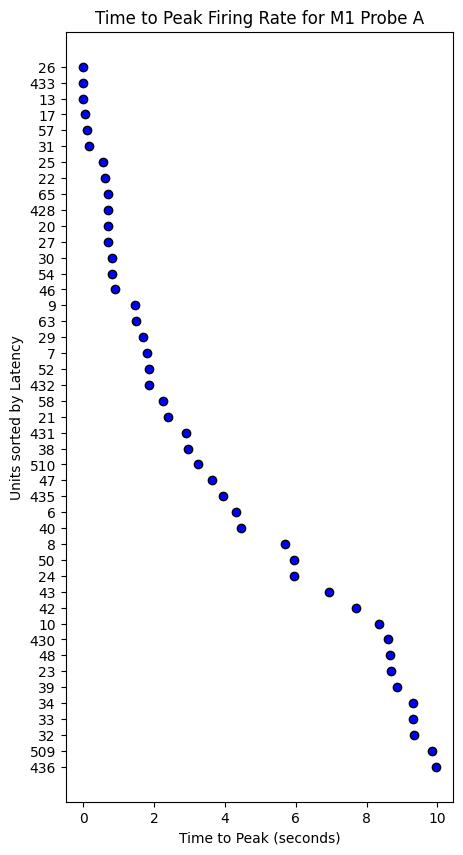

/var/folders/mc/qbcjsrl16h3gf6t6xvz8czzw0000gn/T/ipykernel_1896/102998009.py:2812: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]


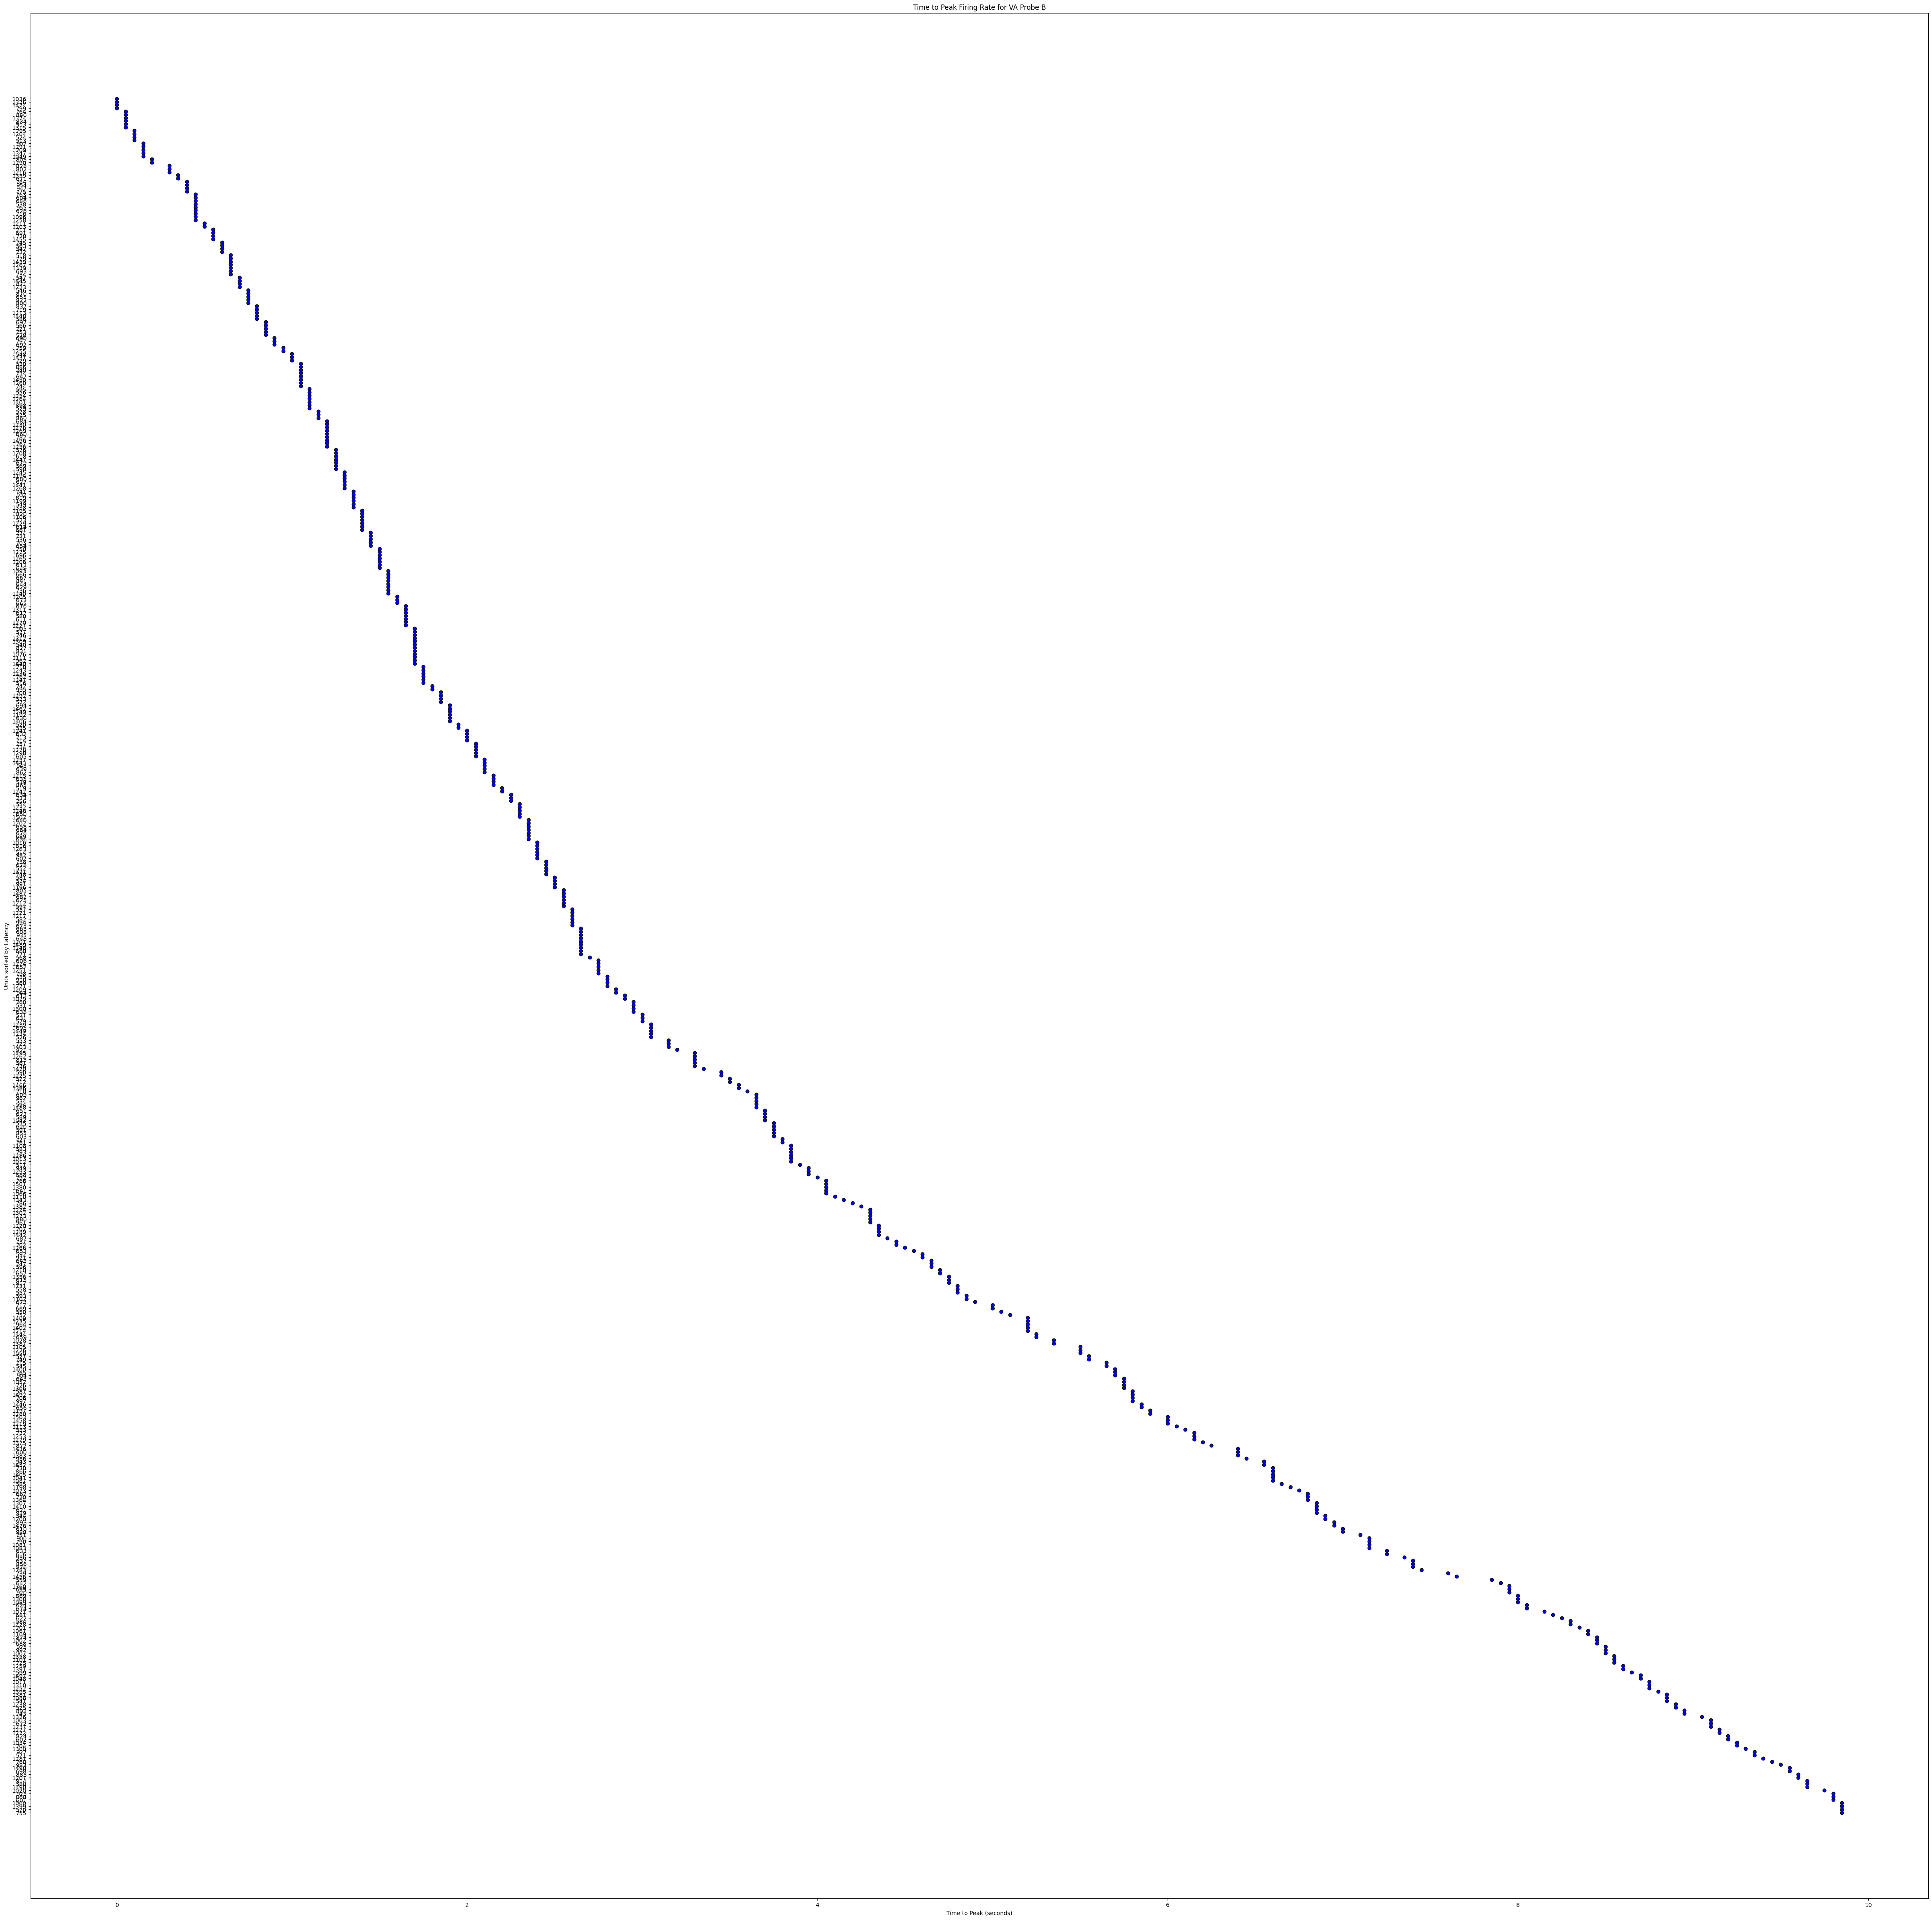

In [54]:
save_fig_path = "/Volumes/T9/gradschool/rotations/jason_christie/analysis/Reach1_4_2024-02-13_18-20-36_001/plot_time_to_peak/probeA/"
mouse_id.plot_peak_latency_scatter('A', 'M1',save_fig_path, Savefig=True,fig_size=(5, 10))

save_fig_path = "/Volumes/T9/gradschool/rotations/jason_christie/analysis/Reach1_4_2024-02-13_18-20-36_001/plot_time_to_peak/probeB/"
mouse_id.plot_peak_latency_scatter('B', 'VA', save_fig_path, Savefig=True,fig_size=(60, 60))

## Creating psth and raster plots for each unit, for each epoch, for each probe. in the function you can specify the path to save the plots, the epoch, the probe, the brain region, the time window, and the highlight color for the time window. In the functions you can change the paths for raster and psth_line to switch which epoch is being plotted. 

In [9]:
save_fig_path = "/Volumes/T9/gradschool/rotations/jason_christie/analysis/Reach1_4_2024-02-13_18-20-36_001/allUnits_pellet_detetced_0/probeA/"
mouse_id.allUnits_pellet_detetced_0('A', 'M1', save_fig_path, Savefig=True)

save_fig_path = "/Volumes/T9/gradschool/rotations/jason_christie/analysis/Reach1_4_2024-02-13_18-20-36_001/allUnits_pellet_detetced_0/probeB/"
mouse_id.allUnits_pellet_detetced_0('B', 'VA', save_fig_path, Savefig=True)

/var/folders/mc/qbcjsrl16h3gf6t6xvz8czzw0000gn/T/ipykernel_32034/1623917176.py:136: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
/var/folders/mc/qbcjsrl16h3gf6t6xvz8czzw0000gn/T/ipykernel_32034/1623917176.py:136: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]


In [13]:
save_fig_path = "/Volumes/T9/gradschool/rotations/jason_christie/analysis/Reach1_4_2024-02-13_18-20-36_001/allUnits_pellet_detetced_01/probeA/"
mouse_id.allUnits_pellet_detetced_0('A', 'M1', save_fig_path, Savefig=True)

save_fig_path = "/Volumes/T9/gradschool/rotations/jason_christie/analysis/Reach1_4_2024-02-13_18-20-36_001/allUnits_pellet_detetced_01/probeB/"
mouse_id.allUnits_pellet_detetced_0('B', 'VA', save_fig_path, Savefig=True)

/var/folders/mc/qbcjsrl16h3gf6t6xvz8czzw0000gn/T/ipykernel_32034/4038512258.py:136: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]
/var/folders/mc/qbcjsrl16h3gf6t6xvz8czzw0000gn/T/ipykernel_32034/4038512258.py:136: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]


/var/folders/mc/qbcjsrl16h3gf6t6xvz8czzw0000gn/T/ipykernel_31330/4236049001.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe==probeLetter][df_units.label==2]


neuron indexs for A [6, 7, 8, 9, 10, 13, 17, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 38, 39, 40, 42, 43, 46, 47, 48, 50, 52, 54, 57, 58, 63, 65, 428, 430, 431, 432, 433, 435, 436, 509, 510]
looking at neuron/unit 23


/Users/grant/opt/anaconda3/lib/python3.9/site-packages/dlab/psth_and_raster.py:202: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  axes.set_ylim(len(triggers),1)
/var/folders/mc/qbcjsrl16h3gf6t6xvz8czzw0000gn/T/ipykernel_31330/4236049001.py:111: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]


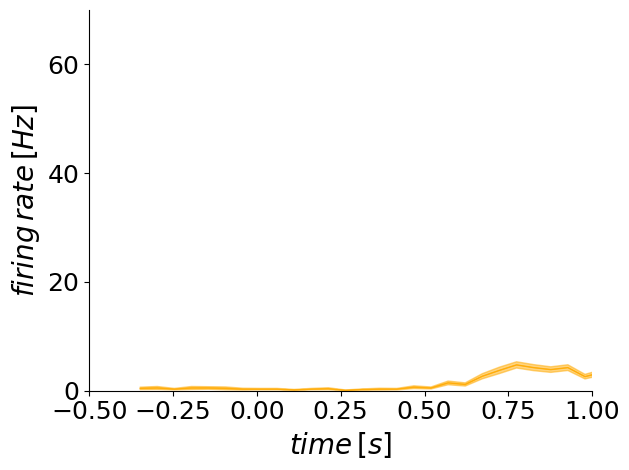

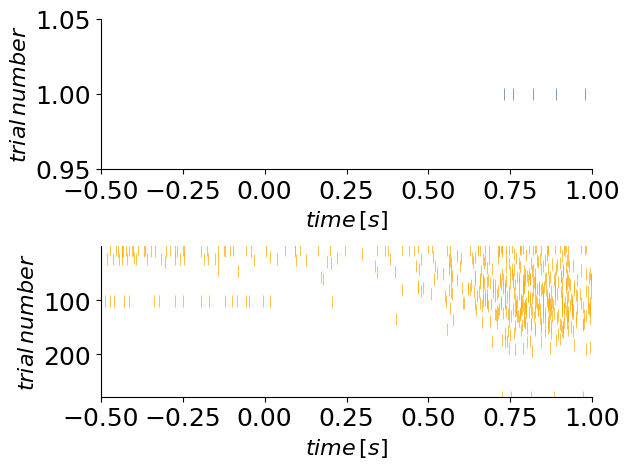

In [33]:
save_fig_path = "/Volumes/T9/gradschool/rotations/jason_christie/analysis/Reach1_4_2024-02-13_18-20-36_001/singleUnit_pellet_detected_plots"
mouse_id.singleUnit_pellet_detected('A', 10, True)

/var/folders/mc/qbcjsrl16h3gf6t6xvz8czzw0000gn/T/ipykernel_31330/2823072374.py:1171: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe == probeLetter][df_units.label == 2]


['pellet_delivery_seconds_txt', 'pellet_detected_seconds_txt', 'pellet_delivery_slow_motion_txt', 'pellet_detected_slow_motion_txt', 'pellet_detected_timestamp', 'pellet_delivery_timestamp', 'frame_events_timestamp', 'all_frames_sideCam_txt', 'frames_in_seconds_openEphys']


IndexError: list index out of range

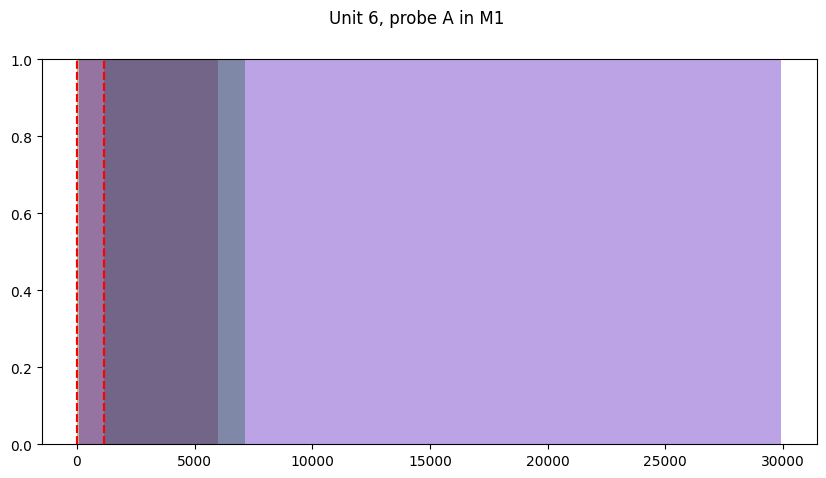

In [28]:
path = '/Volumes/T9/gradschool/rotations/jason_christie/analysis/Reach1_4_2024-02-13_18-20-36_001/full_recording_test_plots'
mouse_id.allUnits_full_recording_psthLined("A", 'M1', path, Savefig=True)

In [5]:
#(probeLetter, brain_region ,path ,Savefig=False):
# path = '/Users/grant/Desktop/work/Grad_School/Rotations/Jason_Cristi/analysis/test_0032023-12-29'
# mouse_id.allUnits_pellet_detetced_0('A',"M1",path,True)

## Step 1
#### verify data in nwb

In [6]:
units_df = mouse_id.units()


In [7]:

# Function to generate random spike times
def generate_random_spike_times():
    return np.sort(np.random.uniform(0, 249, 5000))

# Apply the function to each row in the DataFrame
units_df['spike_times'] = units_df['spike_times'].apply(lambda x: x + generate_random_spike_times())


ValueError: operands could not be broadcast together with shapes (11303,) (5000,) 

In [ ]:
# Assuming you have a DataFrame called 'df'
spike_times_list = units_df['spike_times'].tolist()
spike_times_list[1]

array([4.48067198e-02, 2.09167475e-01, 3.44388911e-01, ...,
       4.97695358e+02, 4.97725902e+02, 4.97943799e+02])

In [ ]:
mouse_id.epochs()

,start_time,stop_time,tags
id,,,
0,8.906667,238.300000,[pellet_detected_seconds]
1,9.300000,238.546667,[pellet_delivery_seconds]
2,2661.000000,36623.000000,[pellet_detected_sideCam_frames]
3,2720.000000,36660.000000,[pellet_delivery_sideCam_frames]
4,0.006667,249.846667,[all_frames_sideCam]
5,0.006667,241.013333,[frames_in_seconds_openEphys]


In [ ]:
for probe in units_df['probe'].unique():
    df = units_df[units_df['probe'] == probe]
    print(f"Probe {probe} has {len(df)} units")


Probe A has 24 units


#### This shows you the different stimulus names in the trials_df
#### this is usefull when running any function that asks for epoch or epoch_opto, you insert one of these stimulus names

In [ ]:
trials_df = mouse_id.trials()
trials_df.head()

for stimulus in trials_df['stimulus'].unique():
    df = trials_df[trials_df['stimulus'] == stimulus]
    print(f"Stimulus: {stimulus} has {len(df)} trials")
trials_df

Stimulus: pellet_detected_seconds has 8 trials
Stimulus: pellet_delivery_seconds has 8 trials
Stimulus: pellet_detected_sideCam_frames has 8 trials
Stimulus: pellet_delivery_sideCam_frames has 8 trials
Stimulus: all_frames_sideCam has 37027 trials
Stimulus: frames_in_seconds_openEphys has 35702 trials


,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
0,8.906667,8.906667,pellet_detected_seconds,0
1,43.433333,43.433333,pellet_detected_seconds,0
2,77.880000,77.880000,pellet_detected_seconds,0
3,97.300000,97.300000,pellet_detected_seconds,0
4,131.660000,131.660000,pellet_detected_seconds,0
...,...,...,...,...
72756,237.986667,237.986667,frames_in_seconds_openEphys,0
72757,237.993333,237.993333,frames_in_seconds_openEphys,0
72758,238.000000,238.000000,frames_in_seconds_openEphys,0


In [ ]:
trials_df[trials_df['stimulus'] == 'pellet_delivery_seconds']

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,
8,9.300000,9.300000,pellet_delivery_seconds,0
9,43.693333,43.693333,pellet_delivery_seconds,0
10,78.126667,78.126667,pellet_delivery_seconds,0
11,97.440000,97.440000,pellet_delivery_seconds,0
12,131.920000,131.920000,pellet_delivery_seconds,0
13,166.726667,166.726667,pellet_delivery_seconds,0
14,201.086667,201.086667,pellet_delivery_seconds,0
15,235.546667,235.546667,pellet_delivery_seconds,0


In [ ]:
trials_df[trials_df['stimulus'] == 'pellet_delivery_pert']

,start_time,stop_time,stimulus,optogenetics_LED_state
id,,,,


In [8]:
trials_df[trials_df['stimulus'] == 'pellet_delivery_washout']

NameError: name 'trials_df' is not defined

In [9]:
epoch_df = mouse_id.epochs()
epoch_df.head()

,start_time,stop_time,tags
id,,,
0,17.940000,5996.500000,[pellet_delivery_seconds_txt]
1,18.433333,5997.006667,[pellet_detected_seconds_txt]
2,92.067398,29940.754079,[pellet_delivery_slow_motion_txt]
3,89.603389,29938.223474,[pellet_detected_slow_motion_txt]
4,1159.850400,7139.458867,[pellet_detected_timestamp]


/var/folders/mc/qbcjsrl16h3gf6t6xvz8czzw0000gn/T/ipykernel_31330/38585006.py:62: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df1 = df_units[df_units.probe==probeLetter][df_units.label==2]
/Users/grant/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:269: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/Users/grant/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:226: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/Users/grant/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_methods.py:258: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/Users/grant/opt/anaconda3/lib/python3.9/site-packages/numpy/core/fromnumeric.py:3464: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/grant/opt/anaconda3/lib/python3.9/site-packages/numpy/c

neuron indexs for A [6, 7, 8, 9, 10, 13, 17, 20, 21, 22, 23, 24, 25, 26, 27, 29, 30, 31, 32, 33, 34, 38, 39, 40, 42, 43, 46, 47, 48, 50, 52, 54, 57, 58, 63, 65, 428, 430, 431, 432, 433, 435, 436, 509, 510]
looking at neuron/unit 6


FileNotFoundError: [Errno 2] No such file or directory: '/Users/danieljdenman/Academics/grants/applications/20230305_R01_NEI_resub/figures/eArch_LM_psth.eps'

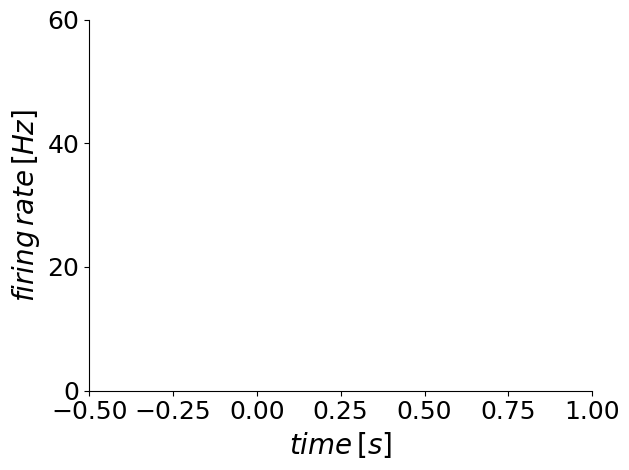

# ***Most important function
## scatter_plot_2()
#### This function takes an epoch and its non-opto counterpart as well as a time window you specify pre and post stimulus onset, it then gatehrs data about all units relative to that timee window and plots it in a raster and psth_line plot 
#### it also creats a dataframe with all the data for each unit and saves it to a csv file
#### you can take this dataframe to the next file in this folder labled 03_findResponsiveUnits_plotChangeFR.ibny , and use it to do the following calaculation
#### it can use the df and its data and find the units that have a specfic response to that stimulus, it can then create box and whisker plots for those responsive units and comapre their change in peak to base FR bwteen the opto and non-opto conditions for that stimulus
#### it can also plot the avg firing rate change between the condtions as a function of depth in a scatter plot so you can see if there is a trend in the data

## Scatter_plot2(): calls this function  
#### allUnits_early_window_matrix(probeLetter, brainRegion,timeWindow, path, pre, post, shift_trigger_start_time, bin_size, epoch, epoch_opto, Savefig=True)
#### this is how the df with all the firining rate data for the sepcificed epoch and time window gets made 
### shift_trigger_start_time --> tells the function how early in ms from stimulus onset or time zero the window to capture spikes. for example setting shift_trigger_start_time = -0.30, will start the time winodw at -300ms from stimulus onset time, good for getting a base line firing rate if you set shift_trigger_start_time=0.10, you then get the base line spikes that occur for each unit from -300ms to -200ms before each stimulus onset 
### post --> this tells the function how long to go forward from the stimulus onset or time set by shift_trigger_start_time to make the window used for captureing avg firing rate. note if shift_trigger_start_time=0.0 and post=0.3, the time window for grabbing spikes will be from 0ms to 300ms relative to stimulus onset. now if you set shift_trigger_start_time=0.3 and post=0.3, you will create a window that captures avg spikes from 300ms to 600ms post stimulus onset
### epoch --> tells tjr function which epoch to look at. it uses the trials_df and looks under the stimulus collumn for a variable with that specific name, it then uses all of the start_times and stop_times in each row for that epoch name, and uses those for the trails in your rater plots. so for example if in the trails_df you have the stimulus named "luminance_flash" and it has 100 rows, each row should have its own start_time and stop_time, it will then use each of those to run the function called raster() and psth_line(), where each trail# in the raster and psth_line plots corrisponds to one row of the "luminance_flash". it also creats a dataframe that gets saved to the path you specify. this df will have onw row for each unit, where it takes the avg FR of all the trials for a specific stimulus. so if you have 100 units, you will get a df out from this function with 100 rows one for each unit. it also has the avg firing rate for the opto and non-otpo condtion 
### bin_size --> bin size in ms to capture avg spikes in
### timeWindow --> can be anything you want. for example i used peak1 to mean the first response of a unit in the time frame 0-150ms after stimulus onset. this value is useful in the next .py file when telling the code what stimulus window to look in/
### probeLetter = "A", "B", "C", this tells the function to look in the units_df and under the probe colmun only use the units that have the corrisponding probe letter 
### brainRegion --> what brain region your probe was in, gets added to file name and df for later recall. 


In [ ]:
path = '/Volumes/T9/gradschool/rotations/jason_christie/analysis/Reach1_4_2024-02-13_18-20-36_001/testing_plots/002' # path to save the dataframes and raster and psth plots

timeWindow = 'pellet_delivery_seconds'
epoch = 'pellet_detected_timestamp' # epoch you want to analyze
epoch_opto = 'pellet_delivery_timestamp' # epoch you want to analyze
shift_trigger_start_time = -0.5 # this is the time you want to start the window after the stimulus onset, can also be negative if you want to start before the stimulus onset 
pre = 0 # this is the time before the shift_trigger_start_time, so if shift_trigger_start_time is 0.150 and pre is 0.5, the window will start at -0.350
post = 3.0 # this is the time after the shift_trigger_start_time, so if shift_trigger_start_time is 0.150 and post is 1.5, the window will end at 1.650
bin_size = 0.005 # this is the bin size for the psth_line plot, so if bin_size is 0.005, the psth_line will have 5ms bins
highlight_color = 'gray' # this is the color you want the window to be highlighted in the raster and psth_line plots
    # def scatter_plot_2(self, probeLetter, brainRegion, timeWindow, path, pre, post, shift_trigger_start_time, bin_size, epoch, epoch_opto, highlight_color,Savefig=True):


fr_base_lum_B= mouse_id.scatter_plot_2("B","M1",timeWindow,path,pre,post,shift_trigger_start_time ,bin_size ,epoch ,epoch_opto,highlight_color)
fr_base_lum_A = mouse_id.scatter_plot_2("A","VA",timeWindow,path,post,pre,shift_trigger_start_time ,bin_size ,epoch ,epoch_opto,highlight_color)
# fr_base_lum_A = mouse_id.scatter_plot_2("C","LP",timeWindow,path,pre,post,shift_trigger_start_time, bin_size  ,epoch ,epoch_opto,highlight_color)
